In [1]:
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from IPython.display import Image
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, norm, skew
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler, scale
from sklearn.svm import SVR
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

warnings.filterwarnings(action="ignore")

In [2]:
# Читається у наборі даних як датафрейм
train = pd.read_csv('..\\data\\train.csv')
test = pd.read_csv('..\\data\\test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

# EDA

## Мета

- Кожен рядок у наборі даних описує характеристики будинку.
- Наша мета - передбачити ціну продажу за цими характеристиками.

In [3]:
# Preview the data we're working with
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

## SalePrice: змінна, яку ми намагаємося передбачити

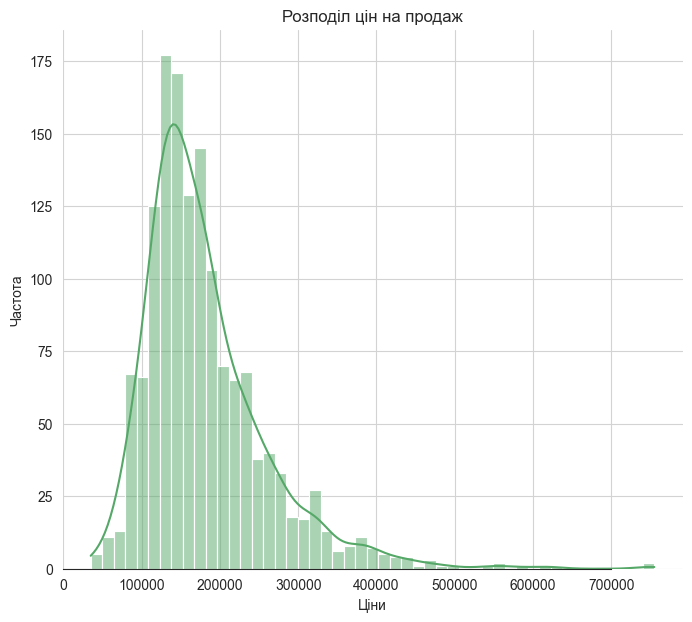

In [4]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.histplot(train['SalePrice'], color="g", kde=True);
ax.xaxis.grid(False)
ax.set(ylabel="Частота")
ax.set(xlabel="Ціни")
ax.set(title="Розподіл цін на продаж")
sns.despine(trim=True, left=True)
plt.grid(c='lightgray')
plt.show()

In [5]:
# Асиметрія і ексцес
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## Особливості: глибоке занурення
Давайте візуалізуємо деякі особливості набору даних

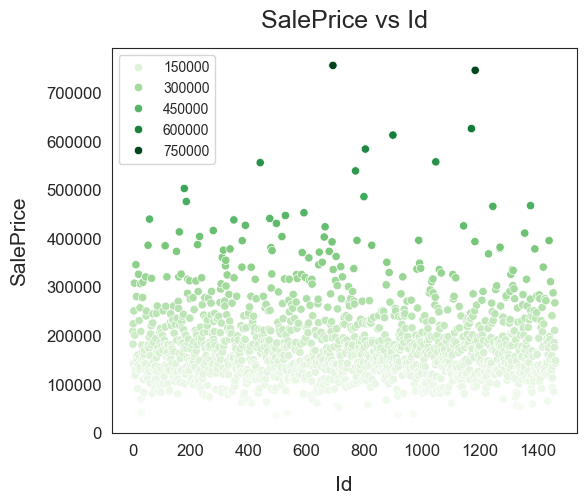

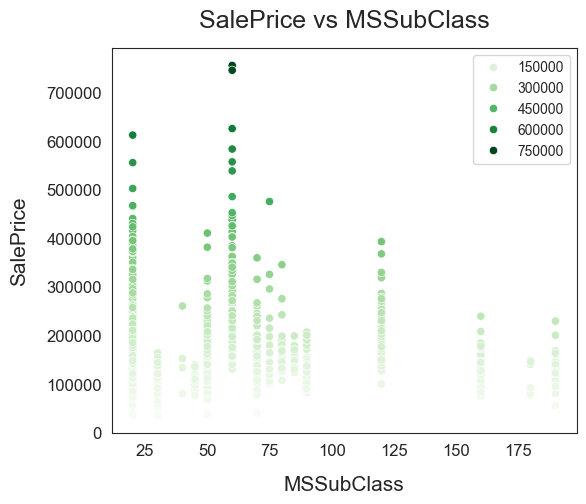

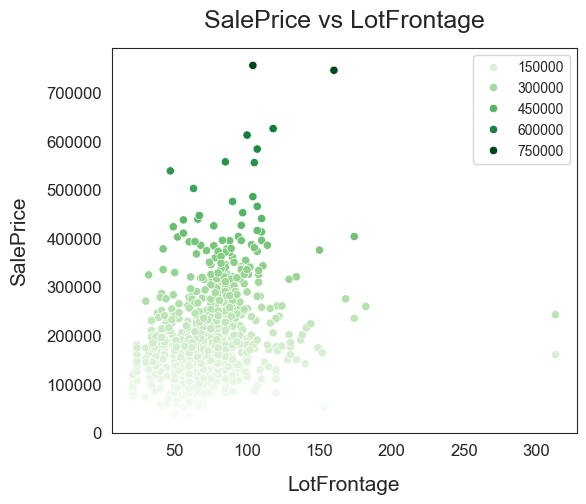

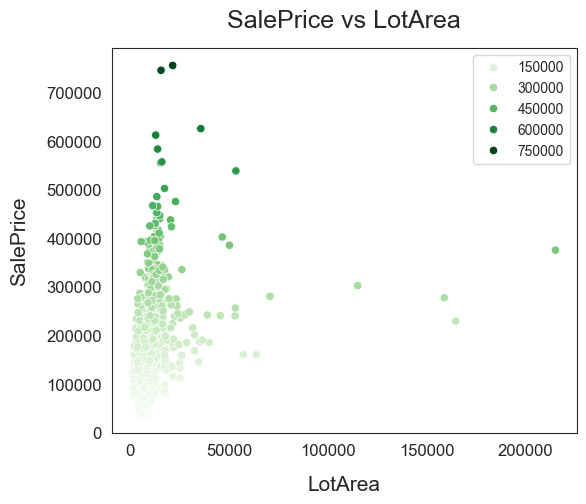

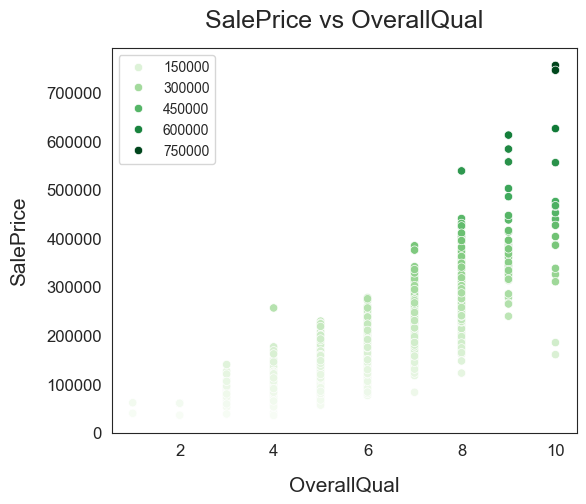

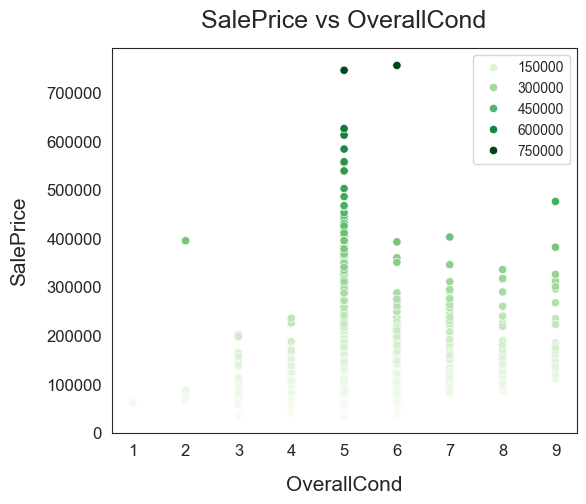

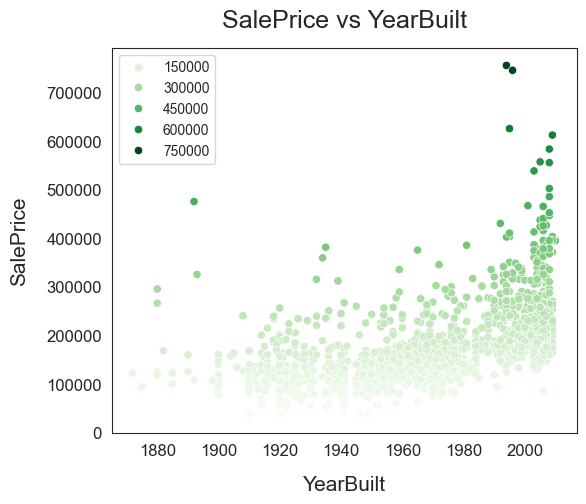

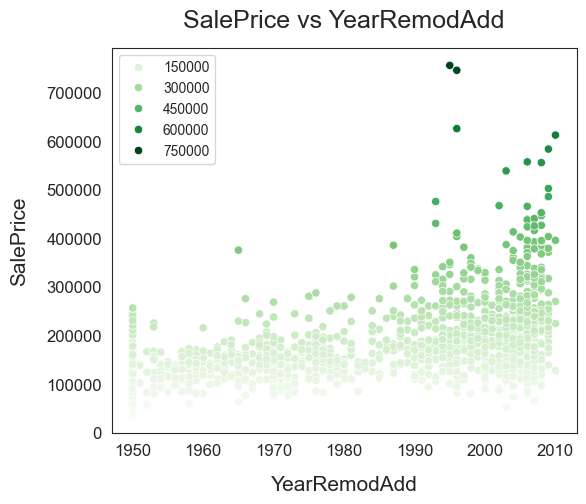

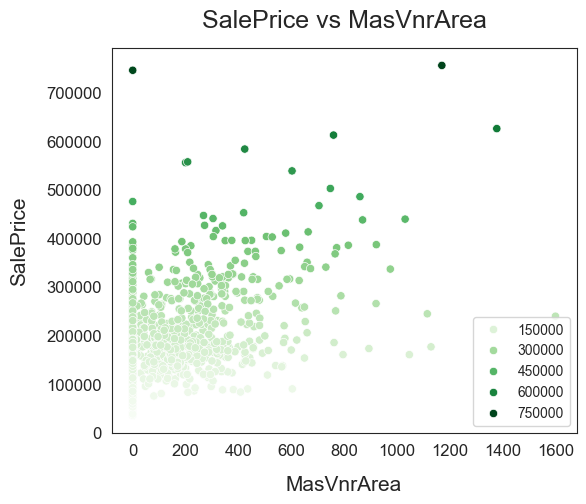

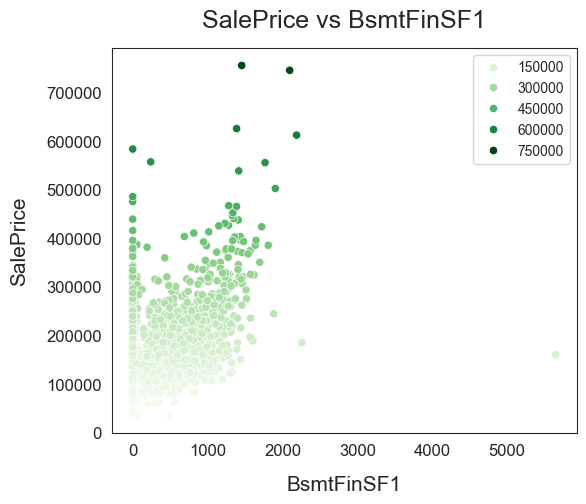

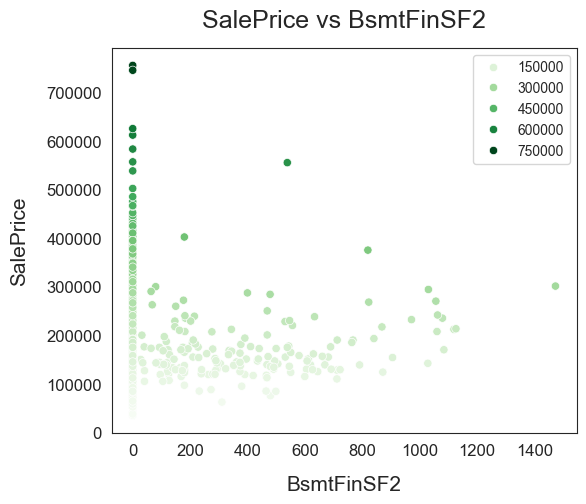

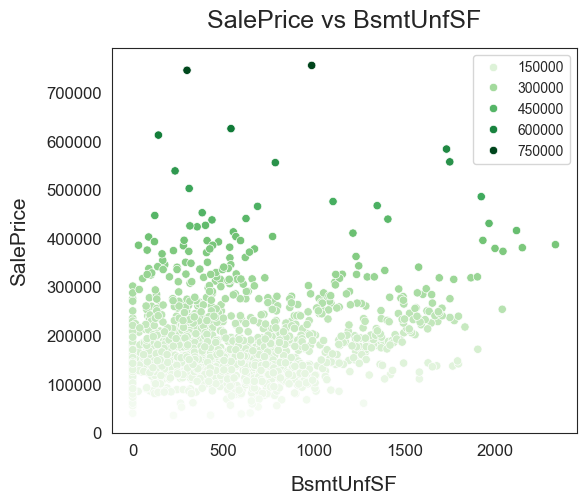

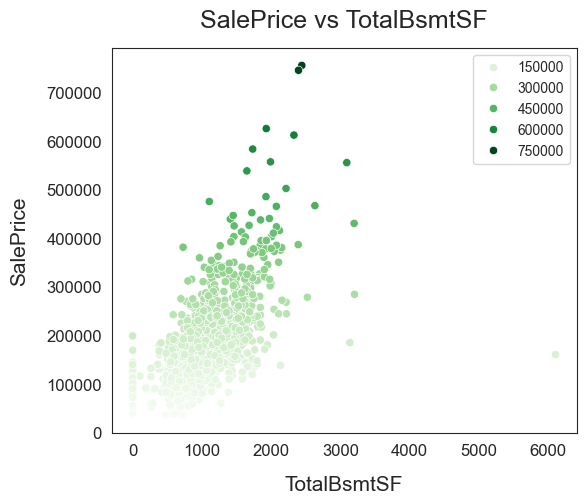

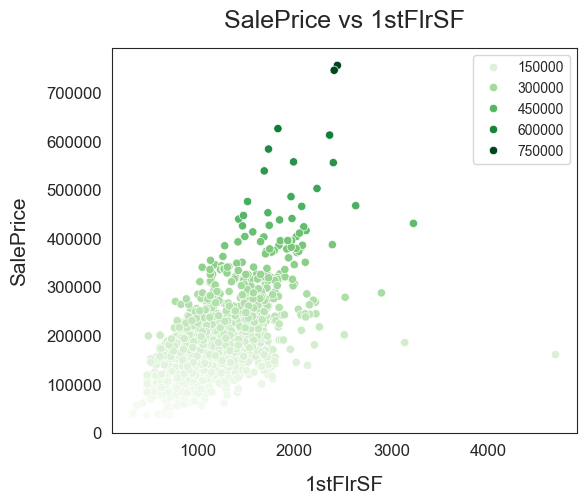

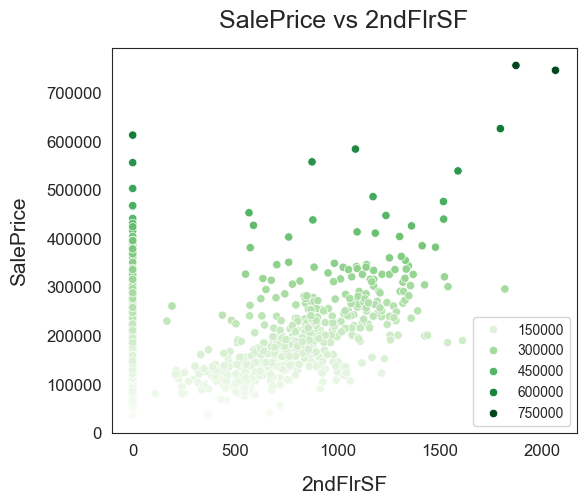

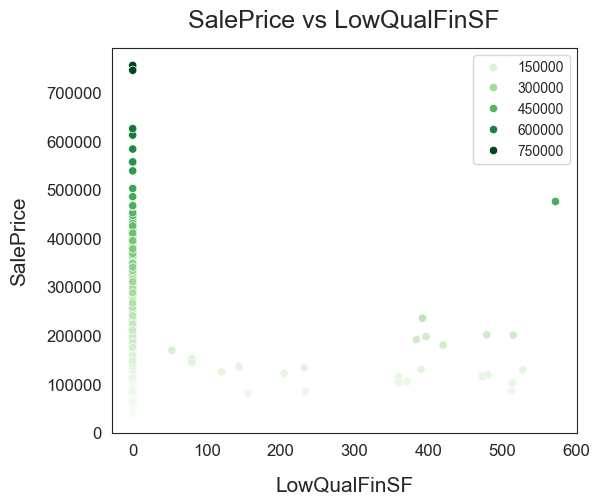

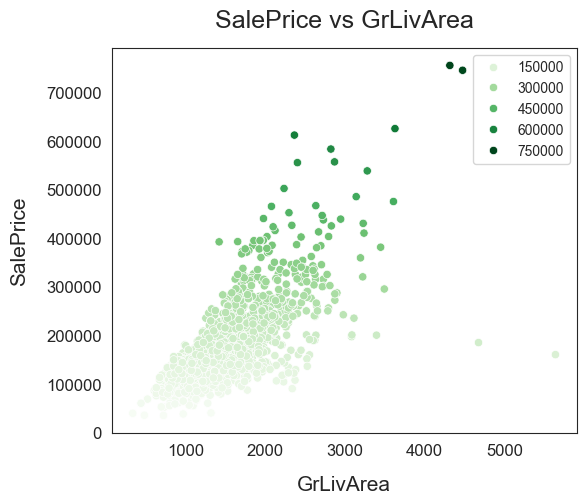

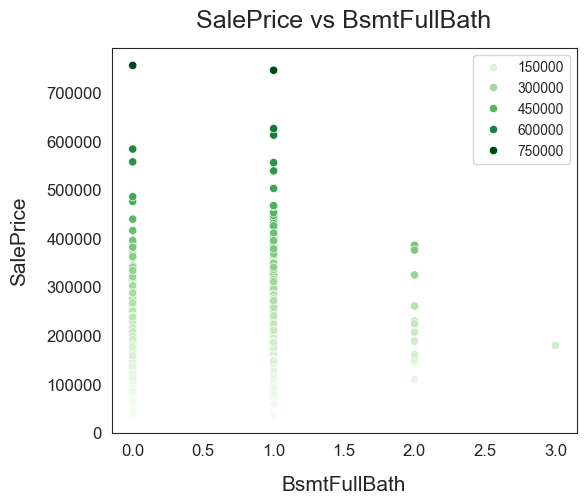

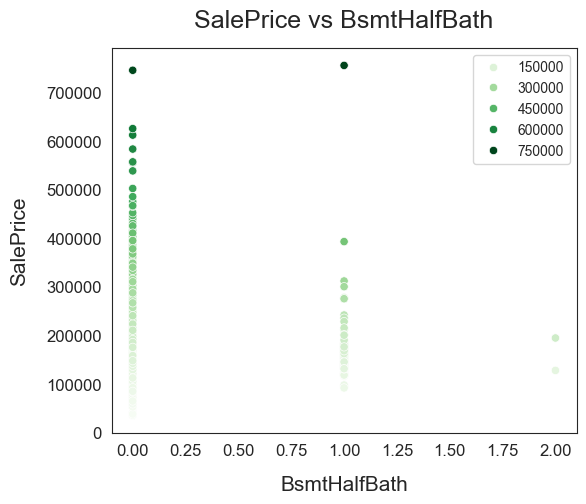

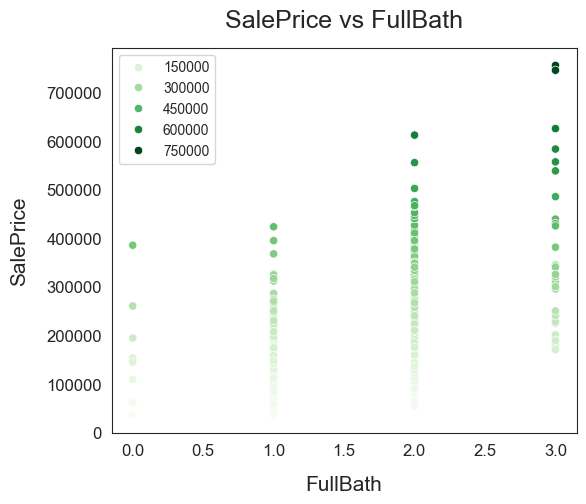

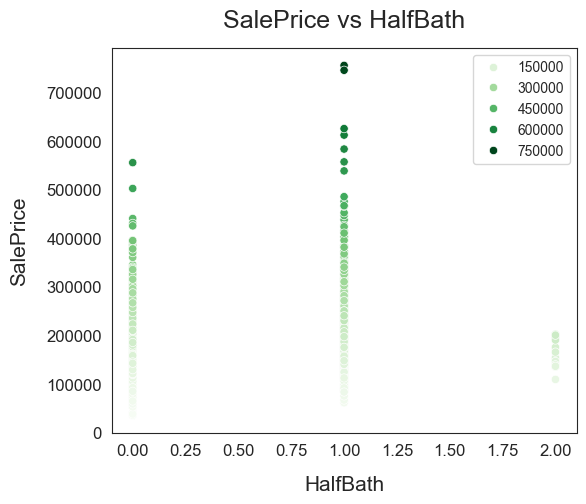

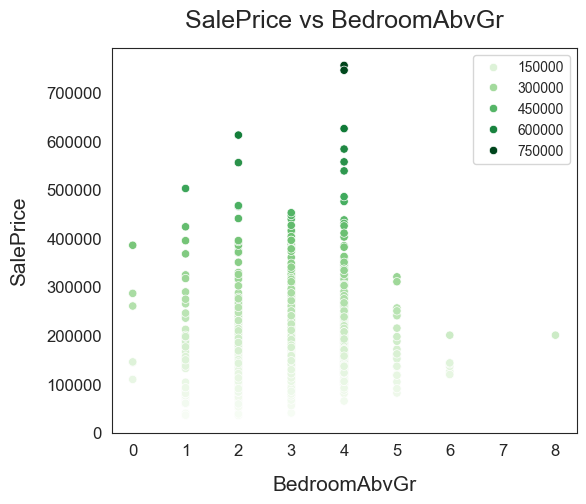

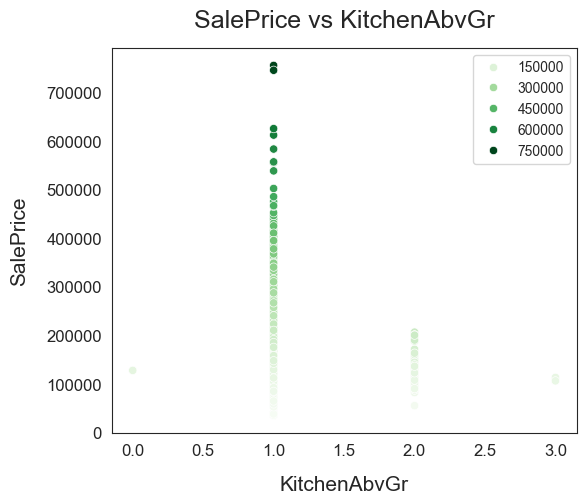

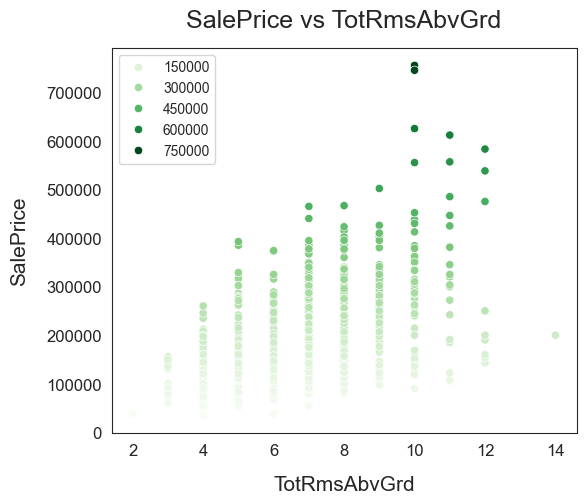

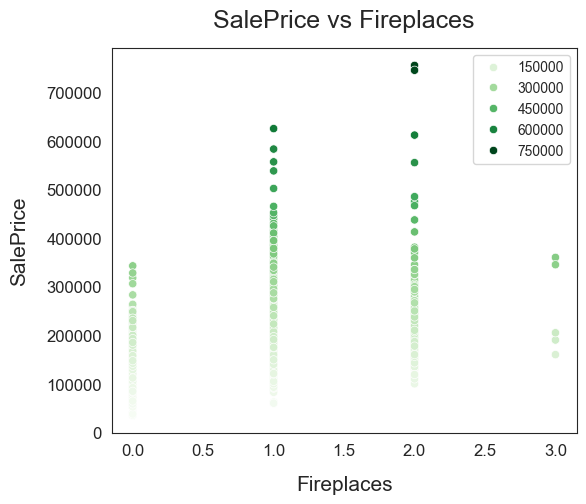

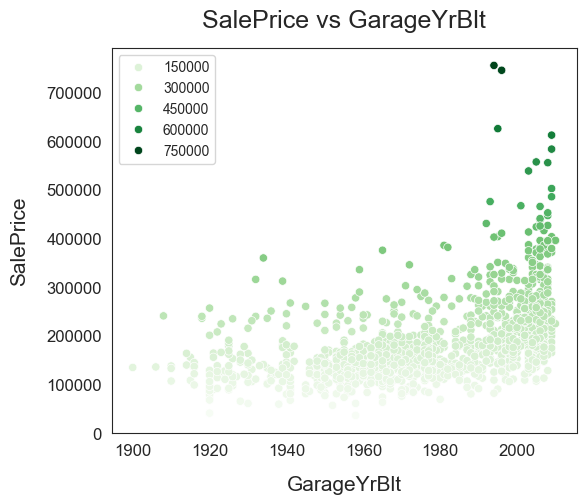

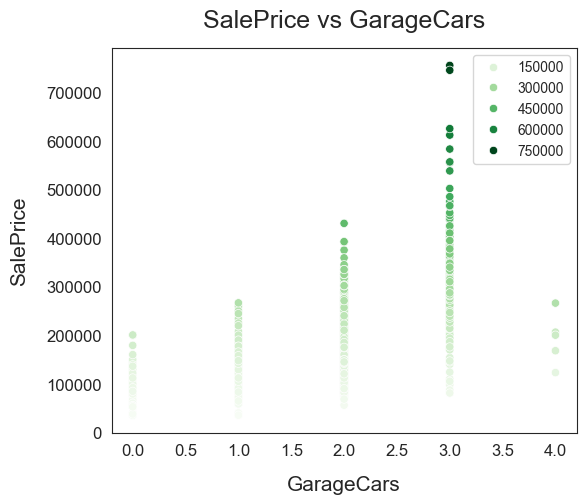

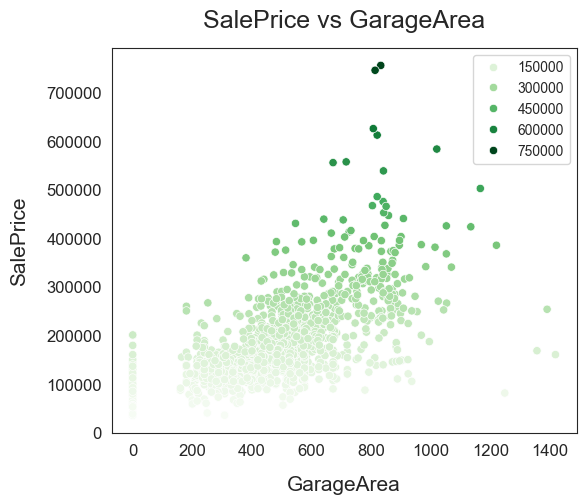

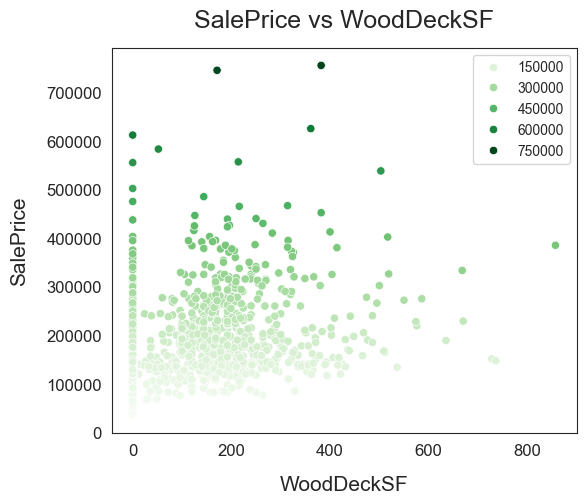

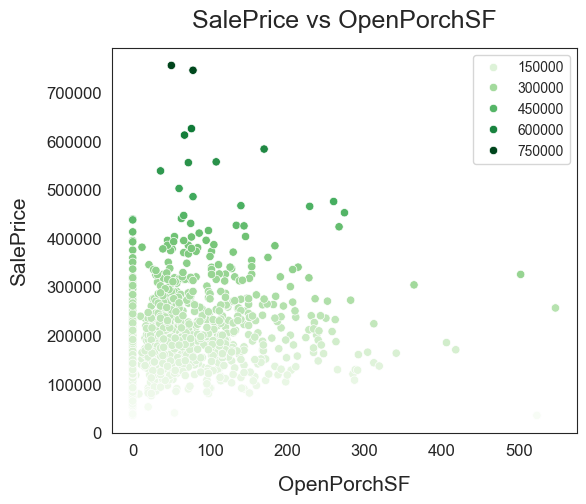

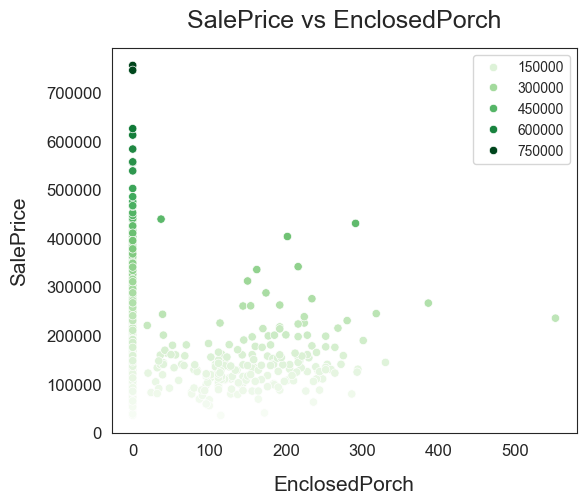

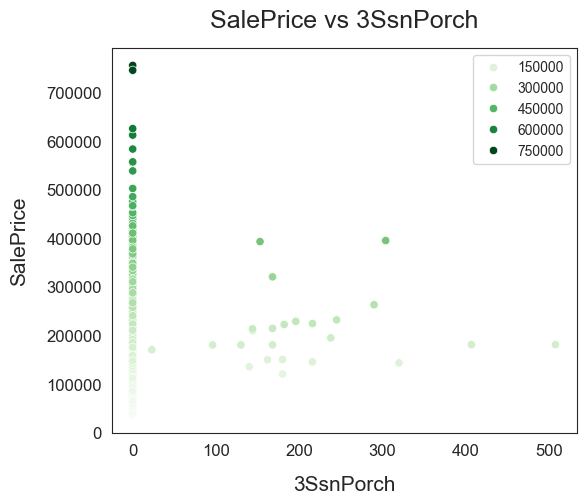

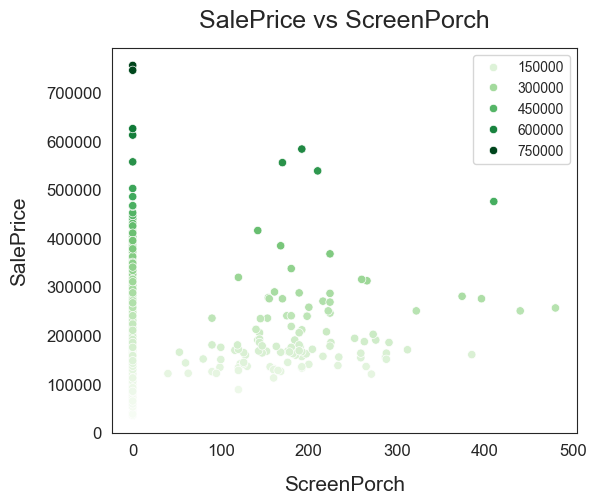

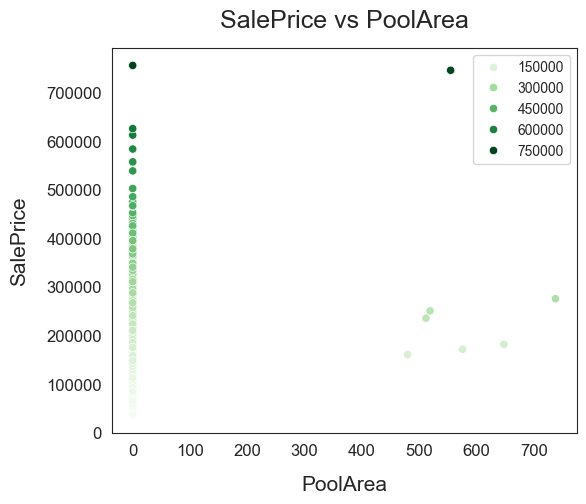

In [6]:
# Пошук числових ознак
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i not in ['TotalSF', 'Total_Bathrooms', 'Total_porch_sf', 'haspool', 'hasgarage', 'hasbsmt', 'hasfireplace']:
            numeric.append(i)

# Візуалізація викидів у значеннях даних
sns.color_palette("husl", 8)
for feature in numeric:
    if feature == 'MiscVal':
        break
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Greens', data=train)
    
    plt.xlabel(f'{feature}', size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    plt.title(f'SalePrice vs {feature}', size=18, pad=15)
    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
    
    plt.show()

і побудуйте графік того, як ознаки корелюють між собою та з SalePrice

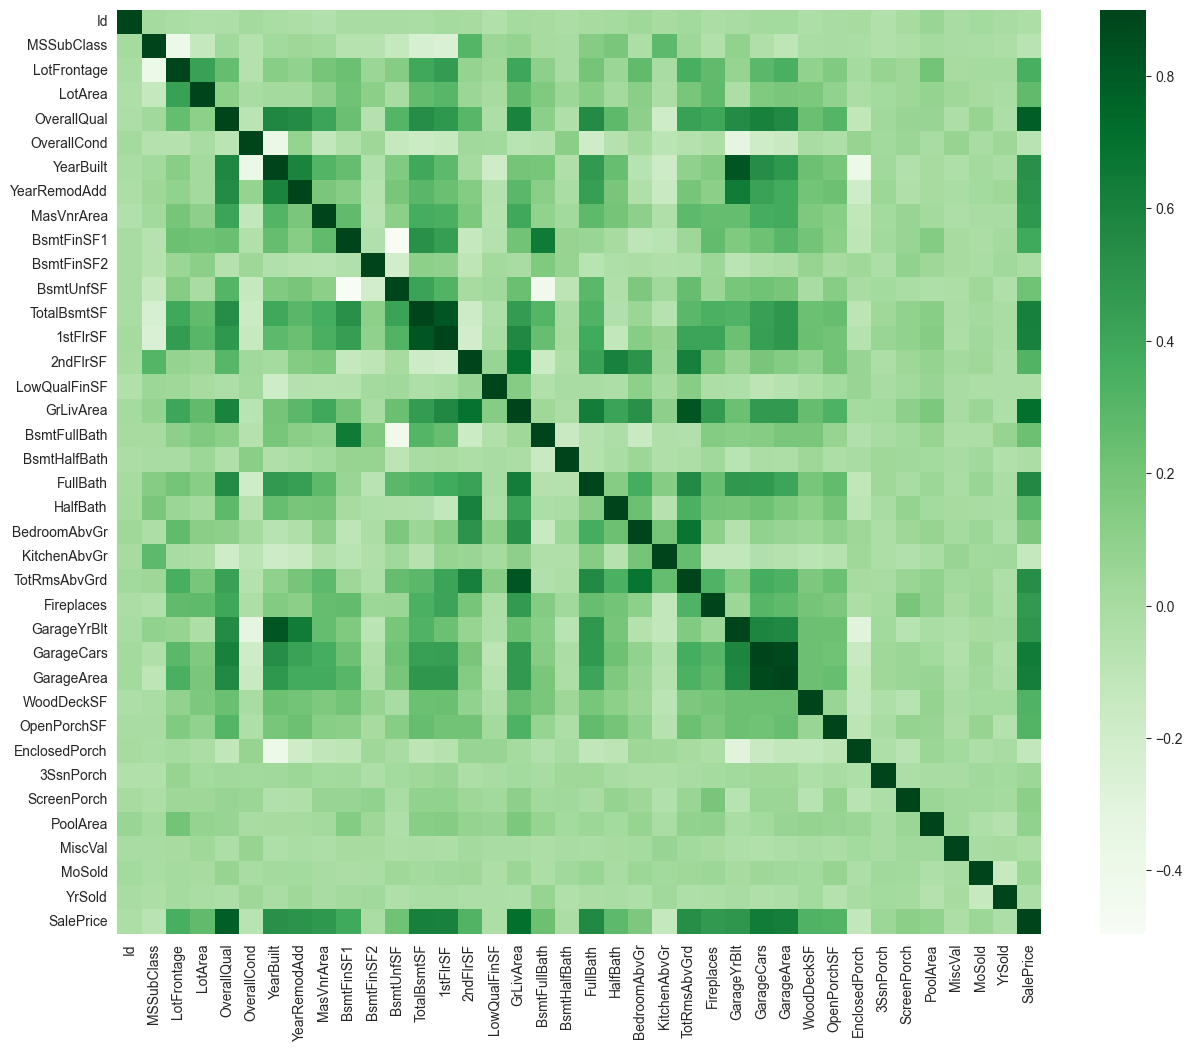

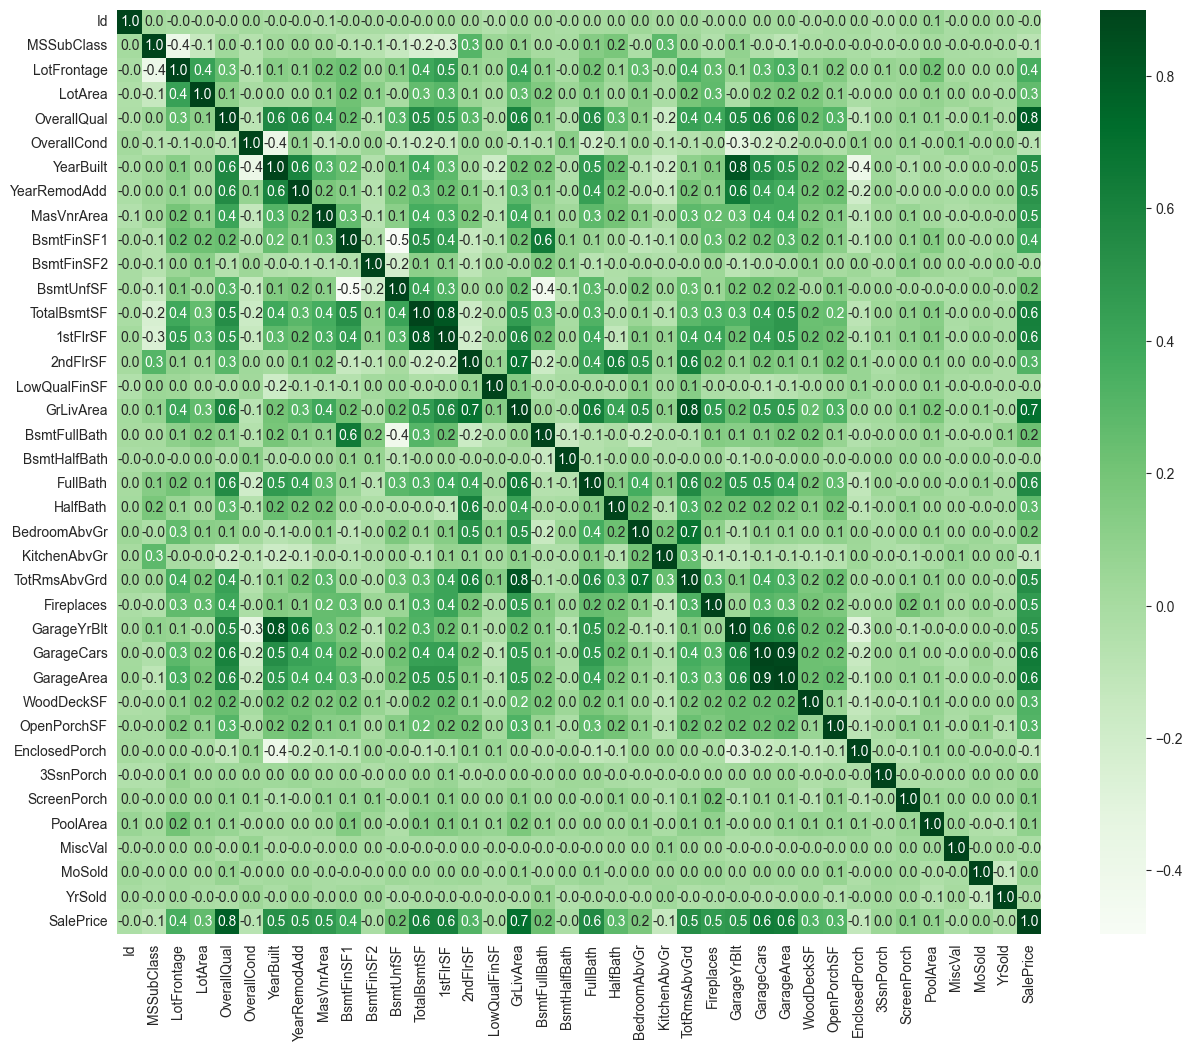

In [7]:
# Відфільтровуємо тільки числові стовпці
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = train.select_dtypes(include=numeric_dtypes)

# Обчислюємо кореляцію тільки для числових стовпців
corr = numeric_cols.corr()

# Візуалізація теплової карти кореляції (без значень)
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, vmax=0.9, cmap="Greens", square=True)
plt.show()

# Візуалізація теплової карти кореляції (зі значеннями)
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, vmax=0.9, cmap="Greens", square=True, annot=True, fmt=".1f")
plt.show()

Давайте подивимося, як SalePrice пов'язаний з деякими характеристиками в наборі даних

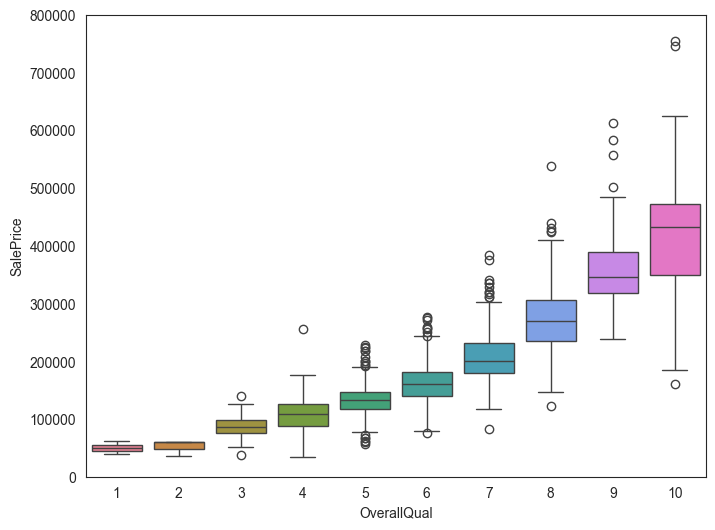

In [8]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data, palette='husl')
fig.axis(ymin=0, ymax=800000);

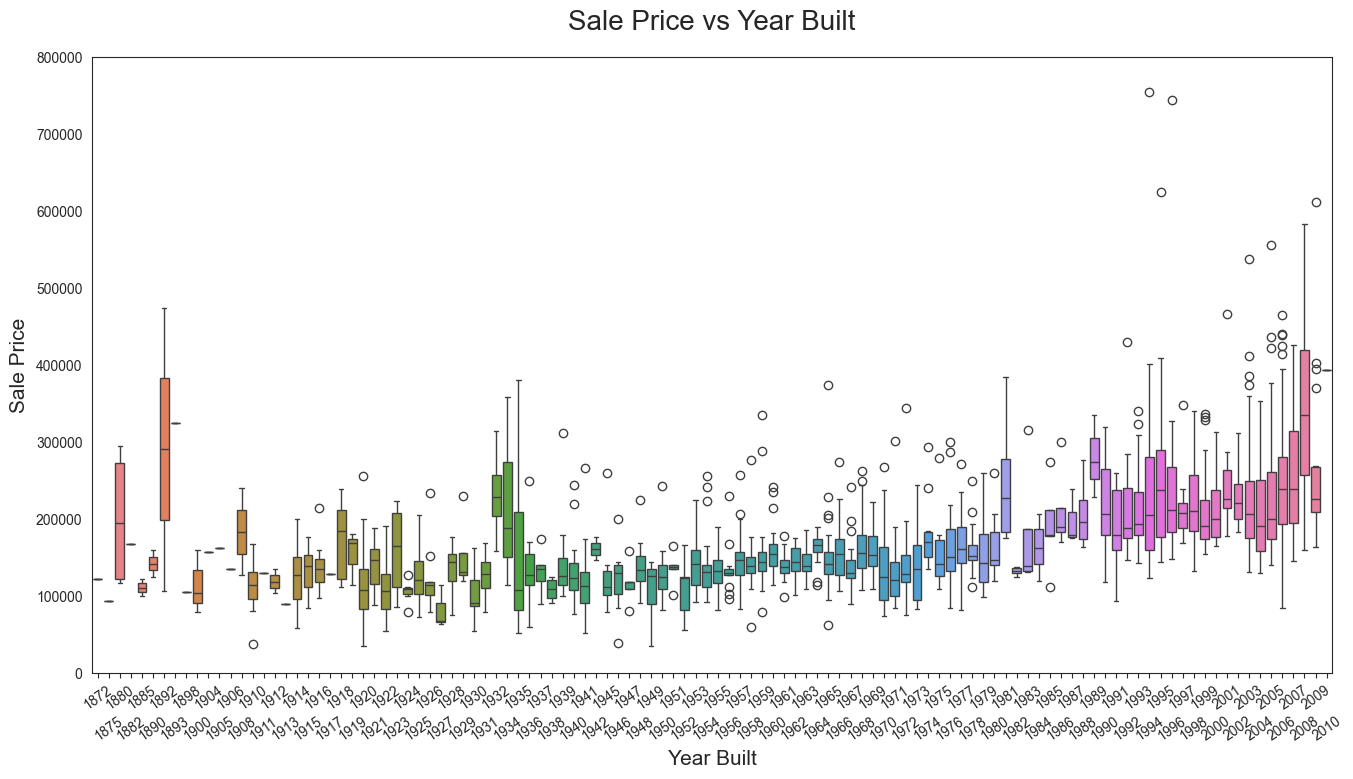

In [9]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data, palette='husl')
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=35);
plt.xlabel('Year Built', fontsize=15, labelpad=5)
plt.ylabel('Sale Price', fontsize=15, labelpad=5)
plt.title('Sale Price vs Year Built', fontsize=20, pad=20);

# Встановлюємо шахове розташування міток на осі x
labels = ax.get_xticklabels()
for i, label in enumerate(labels):
    if i % 2 != 0:
        label.set_y(-0.05)

ax.set_xticklabels(labels)
ax.tick_params(axis='x', which='both', bottom=True, top=False)

# Відображаємо графік
plt.show()

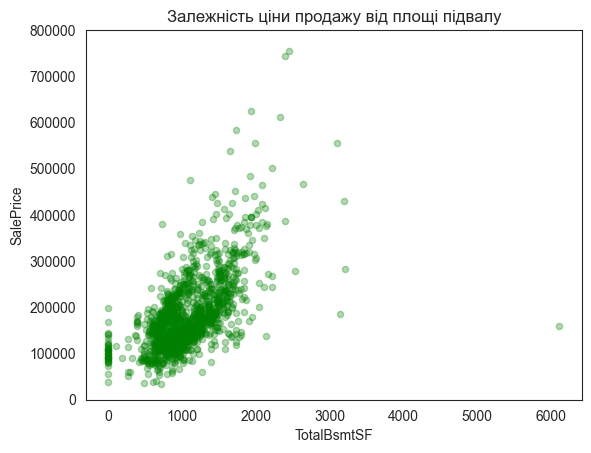

In [10]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0,800000), color='green');
plt.title('Залежність ціни продажу від площі підвалу');

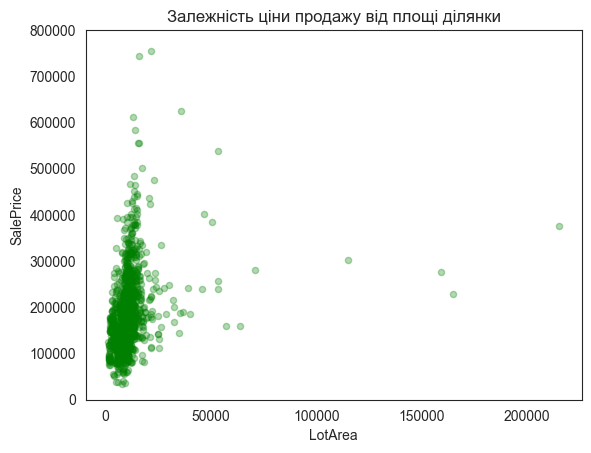

In [11]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, ylim=(0,800000), color='green');
plt.title("Залежність ціни продажу від площі ділянки");

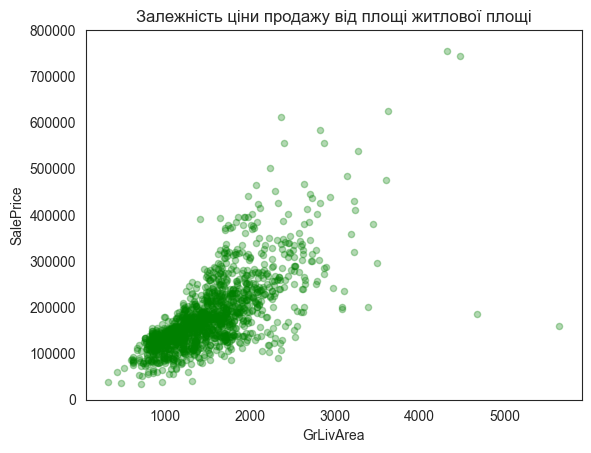

In [12]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000), color='green');
plt.title("Залежність ціни продажу від площі житлової площі");

In [13]:
# Видаліть ідентифікатори з train та test, 
# оскільки вони є унікальними для кожного рядка, а отже, не є корисними для моделі

train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

# Подивимось на розподіл SalePrice

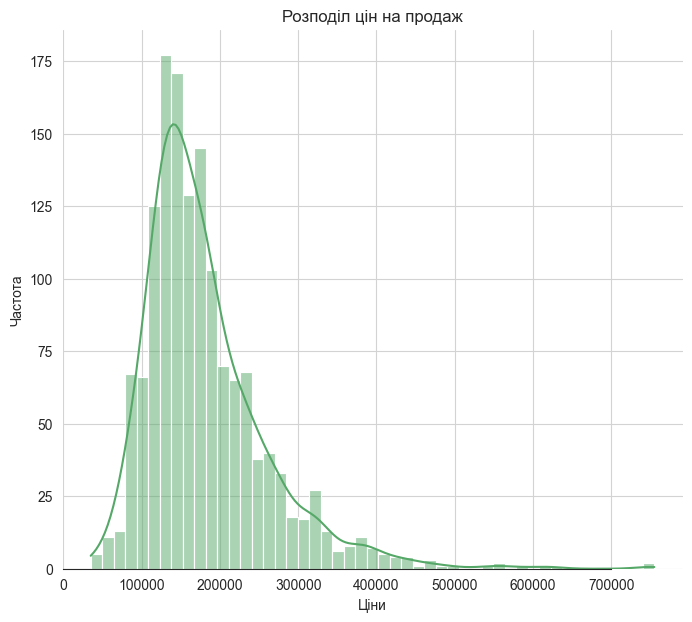

In [14]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
# Check the new distribution 
sns.histplot(train['SalePrice'], color="g", kde=True);
ax.xaxis.grid(False)
ax.set(ylabel="Частота")
ax.set(xlabel="Ціни")
ax.set(title="Розподіл цін на продаж")
sns.despine(trim=True, left=True)
plt.grid(c='lightgray')
plt.show()


Ціна продажу зміщена вправо. Це проблема, тому що більшість моделей ML погано працюють з ненормально розподіленими даними.  
Ми можемо застосувати перетворення log(1+x), щоб виправити нахил.

In [15]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])

Знову побудуємо графік SalePrice.


 mu = 12.024 and sigma = 0.399



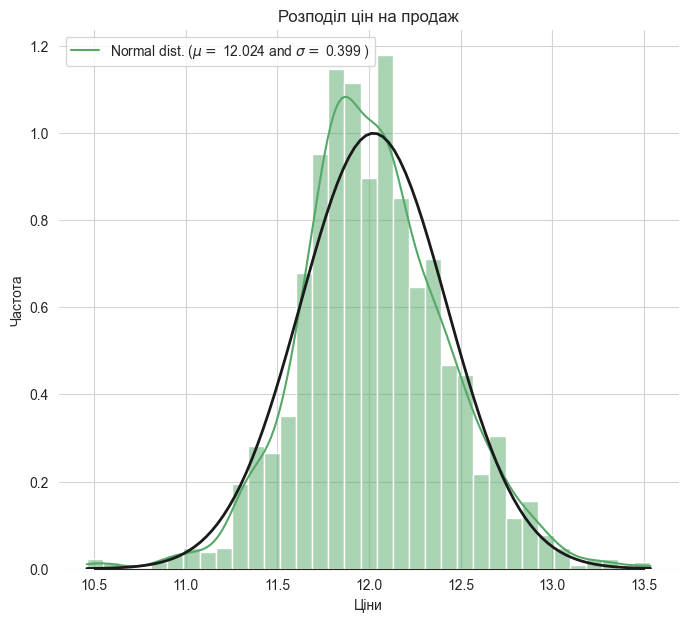

In [16]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.histplot(train['SalePrice'], kde=True, color="g", stat="density");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.3f} and sigma = {:.3f}\n'.format(mu, sigma))

# Plot the fitted normal distribution
(mu, sigma) = norm.fit(train['SalePrice'])
x = np.linspace(min(train['SalePrice']), max(train['SalePrice']), 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.3f} and $\sigma=$ {:.3f} )'.format(mu, sigma)], loc='best');
ax.xaxis.grid(False)
ax.set(ylabel="Частота")
ax.set(xlabel="Ціни")
ax.set(title="Розподіл цін на продаж")
sns.despine(trim=True, left=True)

plt.grid(c='lightgray')
plt.show()

Продажна ціна тепер нормально розподілена, чудово!

In [17]:
# Видалити пропуски
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [18]:
# Розділити функції та мітки
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Об'єднайте навчальні та тестові ознаки, щоб застосувати конвеєр перетворення ознак до всього набору даних
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 79)

## Заповнимо пропущені значення

In [19]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('MasVnrType', 60.54),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45)]

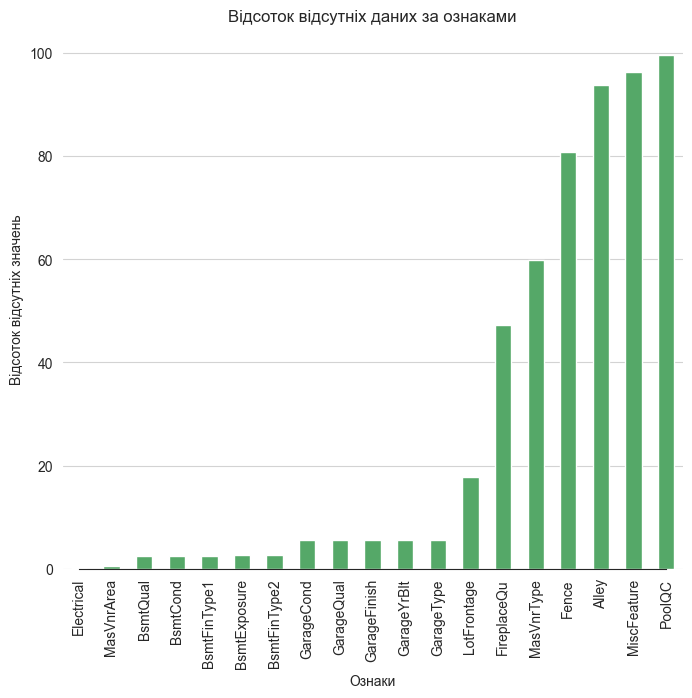

In [20]:
# Візуалізація відсутніх значень
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="g")

# Налаштуйте візуальну презентацію
ax.xaxis.grid(False)
ax.set(ylabel="Відсоток відсутніх значень")
ax.set(xlabel="Ознаки")
ax.set(title="Відсоток відсутніх даних за ознаками")
sns.despine(trim=True, left=True)
plt.grid(c='lightgray', axis='y')

Тепер ми можемо пройтись по кожній з наведених вище ознак та обчислити відсутні значення для кожної з них.

In [21]:
# Деякі з нечислових предикторів зберігаються у вигляді чисел; перетворіть їх у рядки 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [22]:
def handle_missing(features):
    # в описі даних зазначено, що NA відноситься до типових ('Typ') значень
    features['Functional'] = features['Functional'].fillna('Typ')
    # Замініть пропущені значення в кожному з наведених нижче стовпчиків на їхні режими
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # в описі даних вказано, що NA означає "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Заміна відсутніх значень на 0, оскільки немає гаража = немає машин у гаражі
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Заміна відсутніх значень на None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # Значення NaN для цих категорійних ознак підвалу означає, що підвалу немає
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Згрупувати за районами і заповнити пропущене значення медіаною LotFrontage району
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # Ми не маємо особливої інтуїції щодо того, як заповнити решту категорійних ознак
    # Тож ми замінимо їхні відсутні значення на None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # І ми робимо те саме для числових функцій, але цього разу з 0
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [23]:
# Переконаємось, що ми опрацювали всі пропущені значення
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Відсоток відсутніх даних')
df_miss[0:10]

Відсоток відсутніх даних


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

Пропущених значень більше немає!

## Fix skewed features

In [24]:
# Отримати всі числові характеристики
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

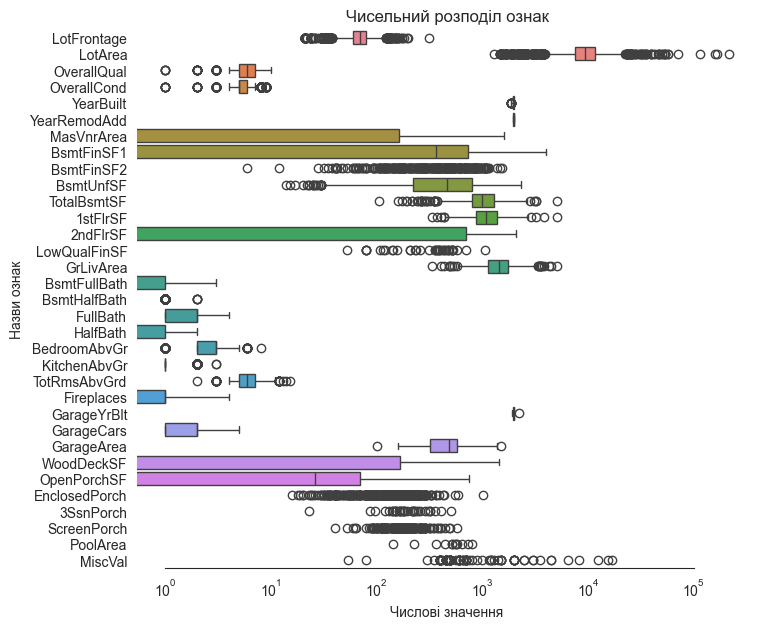

In [25]:
# Створіть блок-діаграми для всіх числових ознак
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="husl")
ax.xaxis.grid(False)
ax.set(ylabel="Назви ознак")
ax.set(xlabel="Числові значення")
ax.set(title="Чисельний розподіл ознак")
sns.despine(trim=True, left=True)

In [26]:
# Знайти перекіс числових функцій
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("Існують {} числових функції з асиметрією > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

Існують 25 числових функції з асиметрією > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

Ми використовуємо функцію scipy boxcox1p, яка обчислює перетворення Бокса-Кокса.  
Мета - знайти просте перетворення, яке дозволить нам нормалізувати дані.

In [27]:
# Попереднє масштабування даних
scaler = MinMaxScaler()
all_features[skew_index] = scaler.fit_transform(all_features[skew_index])

# Нормалізувати викривлені елементи
for i in skew_index:
    try:
        all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))
    except Exception as e:
        print(f"Помилка для функції {i}: {e}")

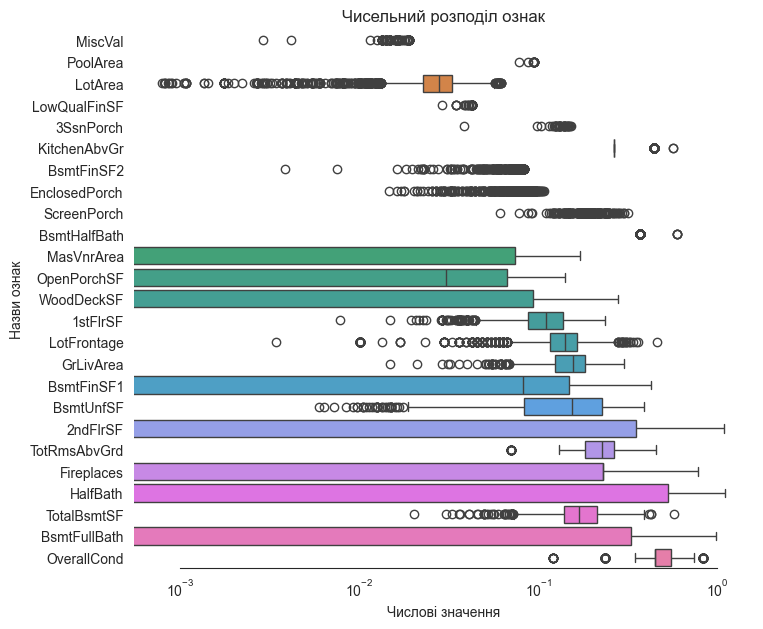

In [28]:
# Переконаємося, що ми обробили всі викривлені значення
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="husl")
ax.xaxis.grid(False)
ax.set(ylabel="Назви ознак")
ax.set(xlabel="Числові значення")
ax.set(title="Чисельний розподіл ознак")
sns.despine(trim=True, left=True)

Зараз всі функції виглядають досить нормально розподіленими.

## Створюйте цікаві функції

Моделі ML мають проблеми з розпізнаванням більш складних шаблонів, тому давайте допоможемо нашим моделям,  
створивши кілька ознак на основі нашої інтуїції щодо набору даних, наприклад, загальну площу поверхів, ванних кімнат та  
площі ґанку кожного будинку.

In [29]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## Перетворення функцій
Створимо більше ознак, обчисливши логарифмічне та квадратичне перетворення наших числових ознак.  
Ми робимо це вручну, тому що ML-моделі не зможуть достовірно визначити, чи є log(feature) або feature^2 предиктором SalePrice.

In [30]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [31]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
                    'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
                    'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

## Кодування категоріальних ознак
Числове кодування категорійних ознак, оскільки більшість моделей можуть обробляти лише числові ознаки.

In [32]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 379)

In [33]:
all_features.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     0.128626  0.025508            7     0.449110       2003          2003   
1     0.164219  0.028435            6     0.737629       1976          1976   
2     0.136030  0.032206            7     0.449110       2001          2002   
3     0.115948  0.028313            7     0.449110       1915          1970   
4     0.173138  0.037972            8     0.449110       2000          2000   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    0.084503    0.143472         0.0   0.058752     0.148574  0.085237   
1   54.598150    0.185297         0.0   0.103268     0.207809  0.127695   
2    0.074088    0.104869         0.0   0.145939     0.158328  0.093019   
3   54.598150    0.050397         0.0   0.172314     0.132998  0.097766   
4    0.118322    0.134934         0.0   0.160226     0.191362  0.117009   

     2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0    0.431025           0.0   0.179990      0.331125      0.000000         2   
1  665.141633           0.0   0.139257      0.000000      0.371346         2   
2    0.437309           0.0   0.185803      0.331125      0.000000         2   
3    0.379925           0.0   0.180537      0.331125      0.000000         1   
4    0.535969           0.0   0.212997      0.331125      0.000000         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0  0.529494             3       0.26428      0.297735    0.000000   
1  0.000000             3       0.26428      0.225485    0.231278   
2  0.529494             3       0.26428      0.225485    0.231278   
3  0.000000             3       0.26428      0.263953    0.231278   
4  0.529494             4       0.26428      0.327608    0.231278   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0       2003.0         2.0       548.0    0.000000     0.060524   
1       1976.0         2.0       460.0    0.142430     0.000000   
2       2001.0         2.0       608.0    0.000000     0.045603   
3       1998.0         3.0       642.0    0.000000     0.039331   
4       2000.0         3.0       836.0    0.104047     0.075162   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  BsmtFinType1_Unf  \
0       0.000000        0.0          0.0       0.0      0.0                 0   
1       0.000000        0.0          0.0       0.0      0.0                 0   
2       0.000000        0.0          0.0       0.0      0.0                 0   
3       0.095542        0.0          0.0       0.0      0.0                 0   
4       0.000000        0.0          0.0       0.0      0.0                 0   

   HasWoodDeck  HasOpenPorch  HasEnclosedPorch  Has3SsnPorch  HasScreenPorch  \
0            1             0                 1             1               1   
1            0             1                 1             1               1   
2            1             0                 1             1               1   
3            1             0                 0             1               1   
4            0             0                 1             1               1   

   YearsSinceRemodel  Total_Home_Quality   TotalSF  YrBltAndRemod  \
0                  5            7.449110  0.664836           4006   
1                 31            6.737629  0.335504           3952   
2                  6            7.449110  0.688656           4003   
3                 36            7.449110  0.610689           3885   
4                  8            8.449110  0.844340           4000   

   Total_sqr_footage  Total_Bathrooms  Total_porch_sf  haspool  has2ndfloor  \
0           0.659733         2.595872        0.060524        0            1   
1           0.312992         2.185673        0.142430        0            1   
2           0.635197         2.595872        0.045603        0            1   
3           0.528088         1.331125        0.134873        0            1   


In [34]:
all_features.shape

(2917, 379)

In [35]:
# Видаліть усі назви стовпців, що повторюються
all_features = all_features.loc[:,~all_features.columns.duplicated()]

## Відтворення навчальних та тестових наборів

In [36]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 378), (1458,), (1459, 378))

In [37]:
X.to_csv('..//data//X.csv', index=False)

Візуалізуйте деякі ознаки, якими ми будемо навчати наші моделей.

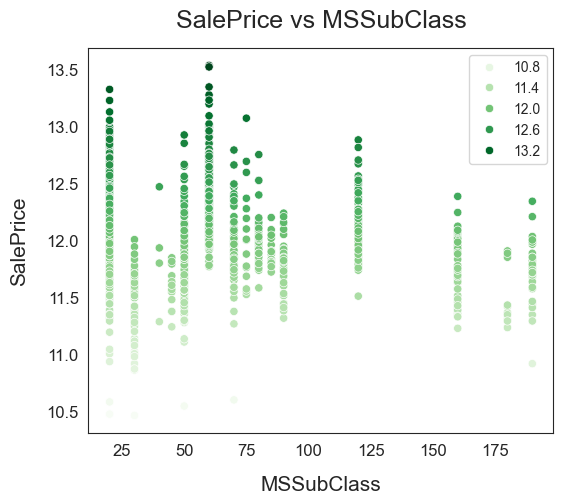

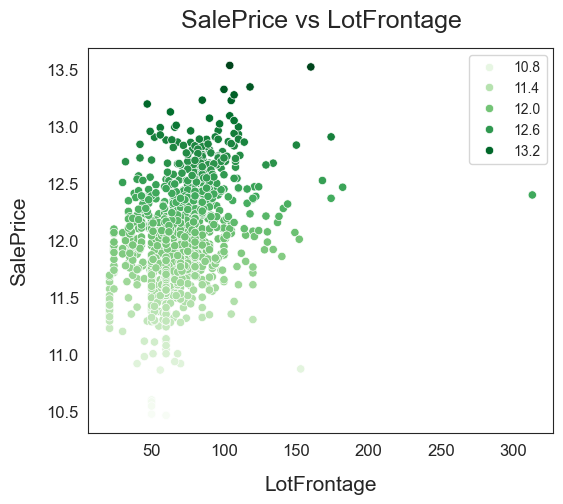

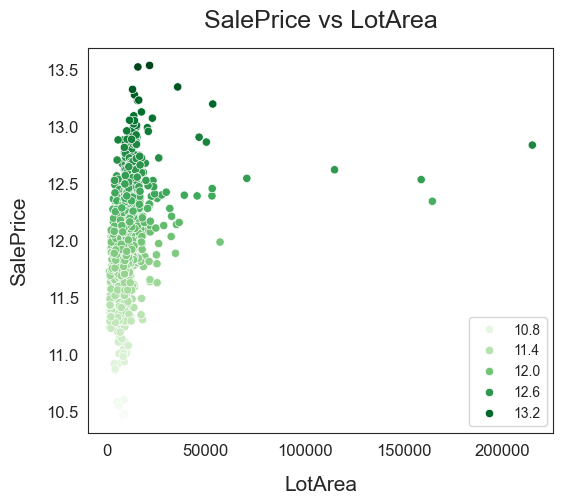

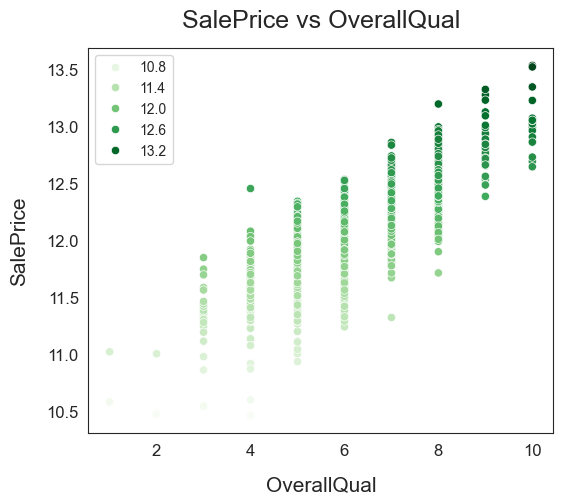

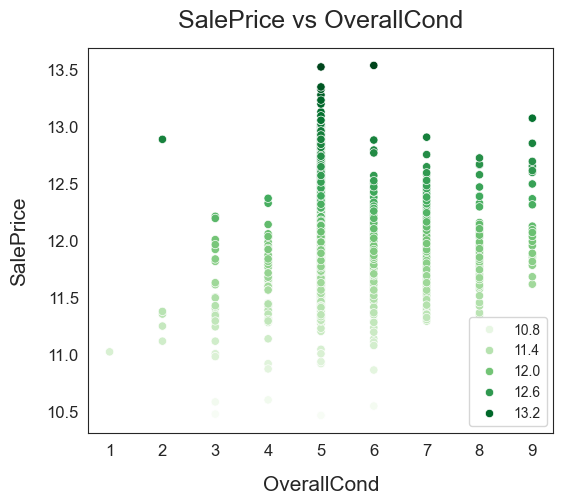

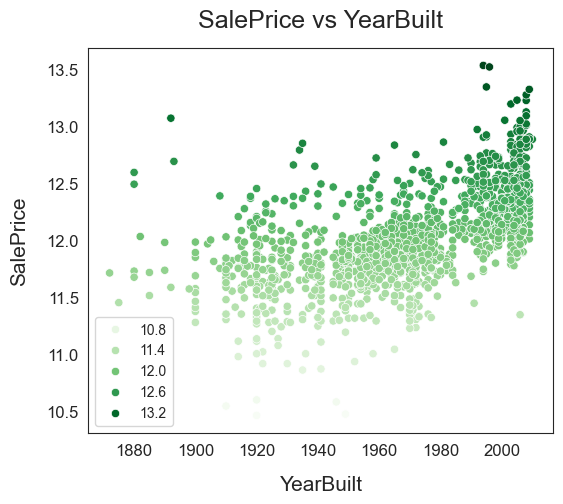

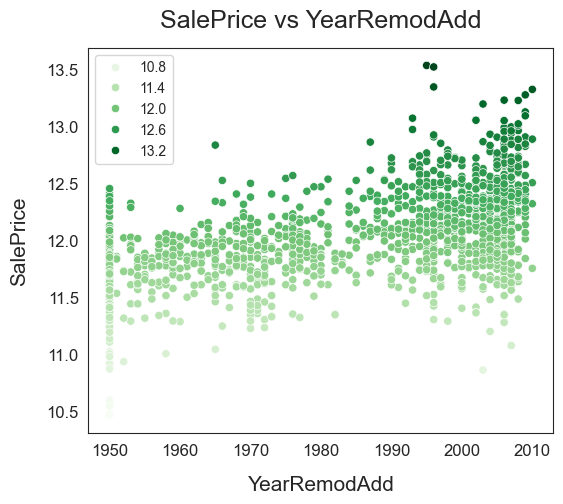

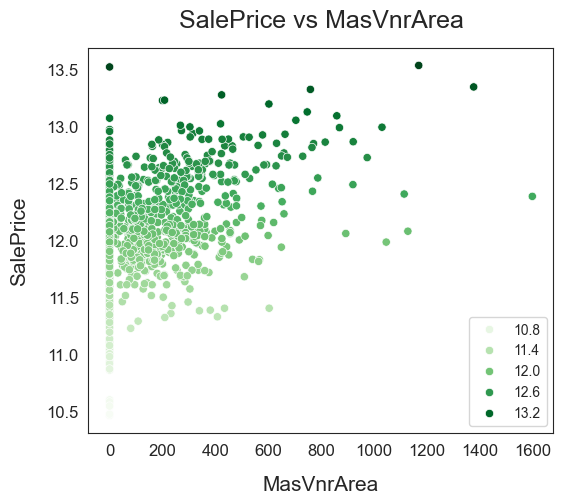

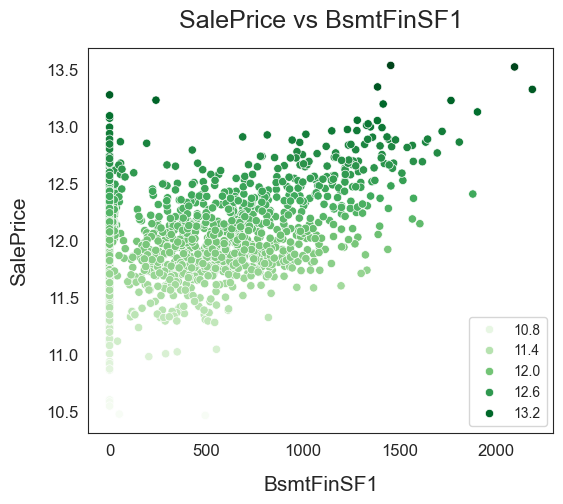

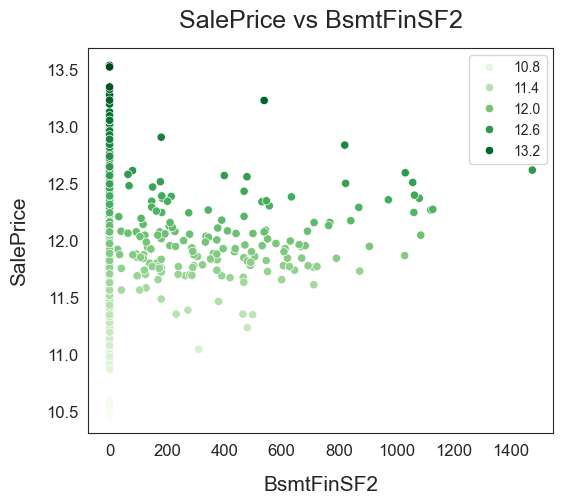

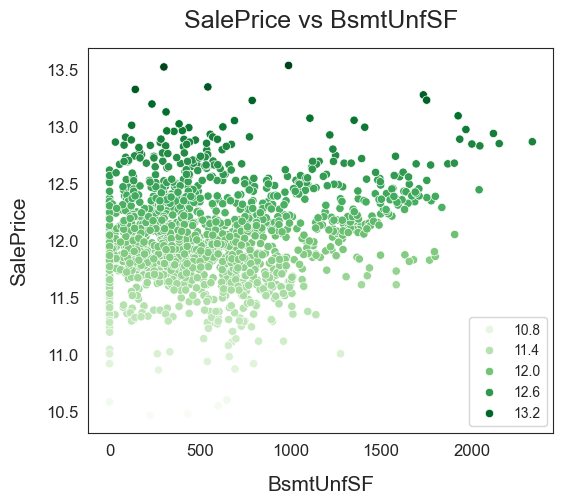

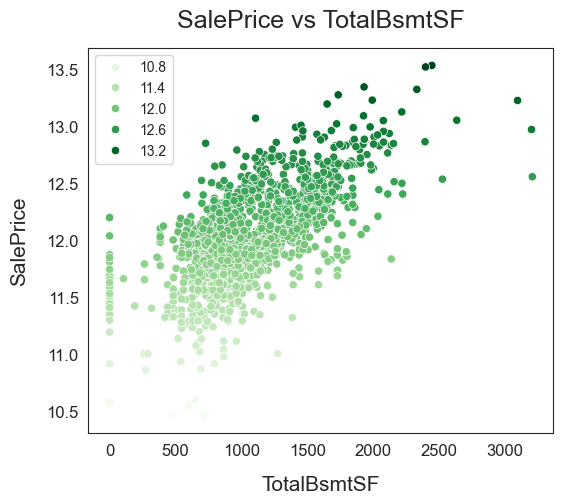

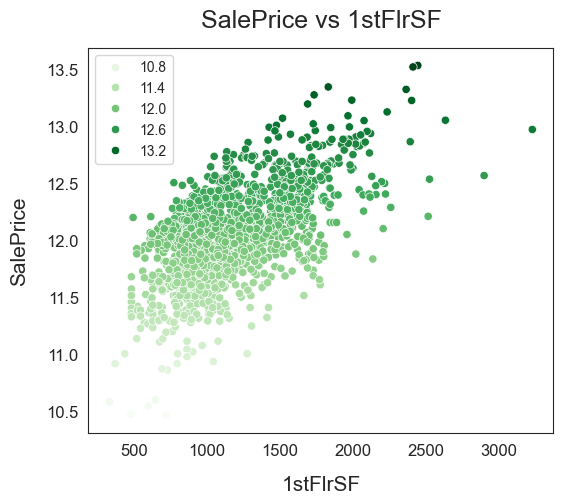

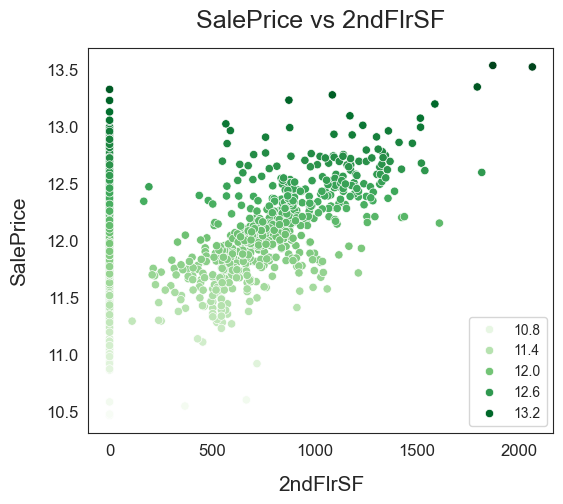

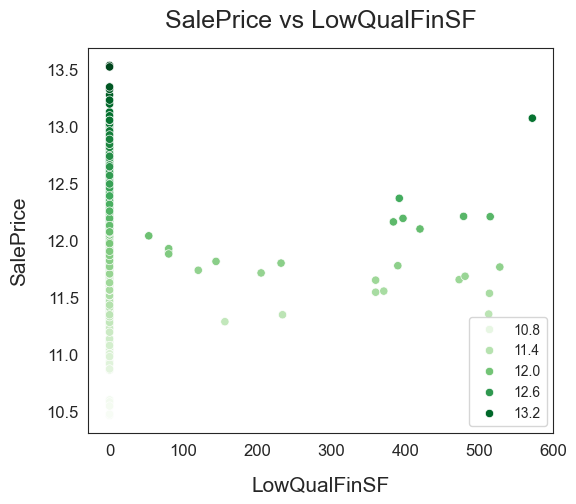

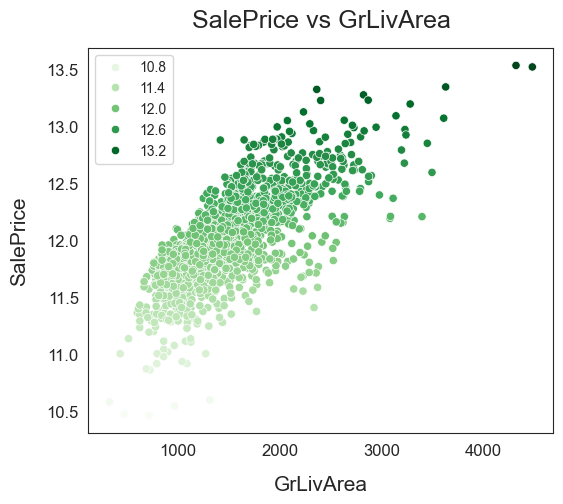

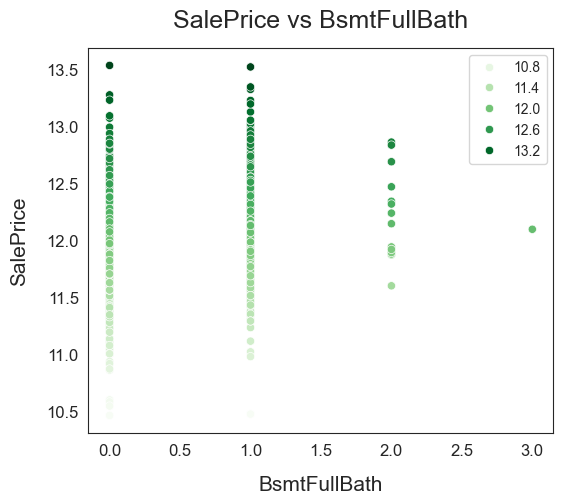

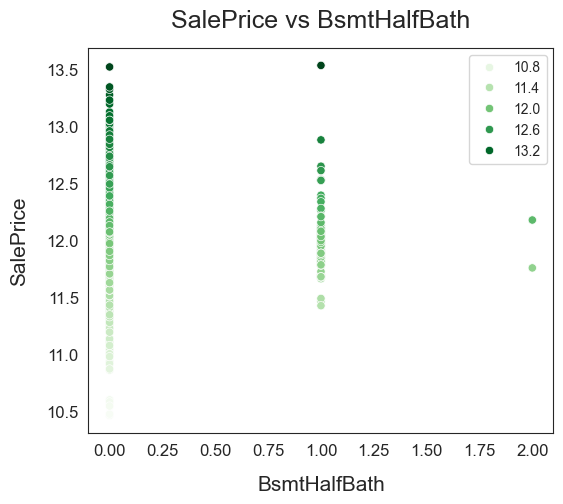

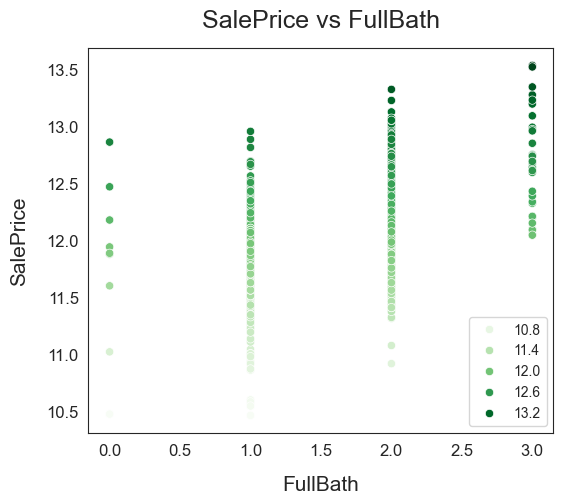

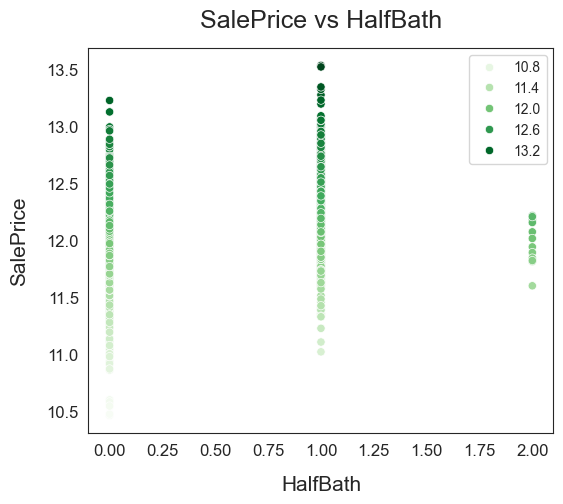

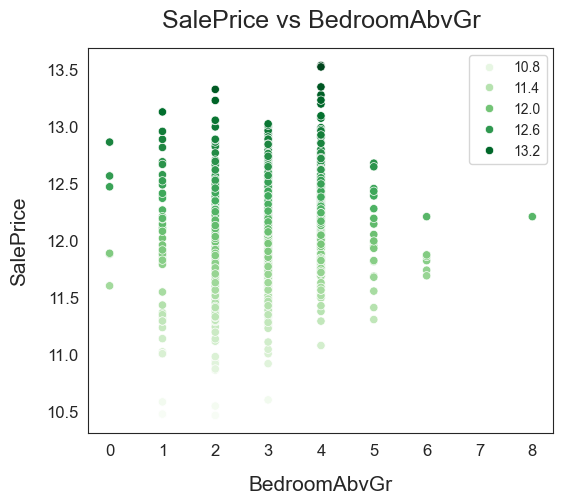

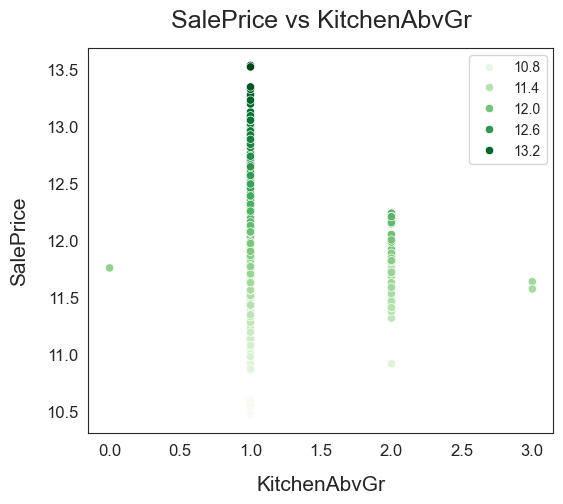

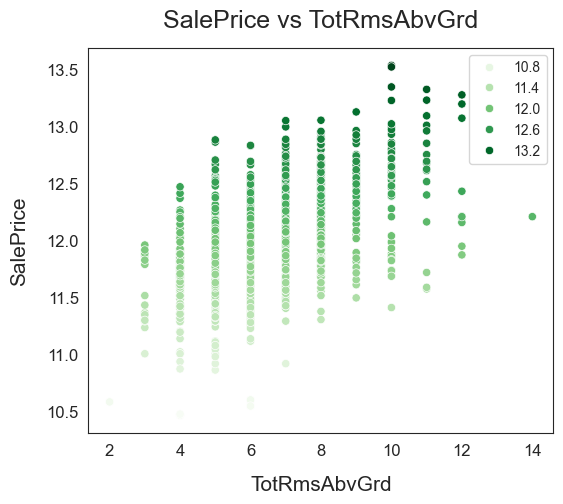

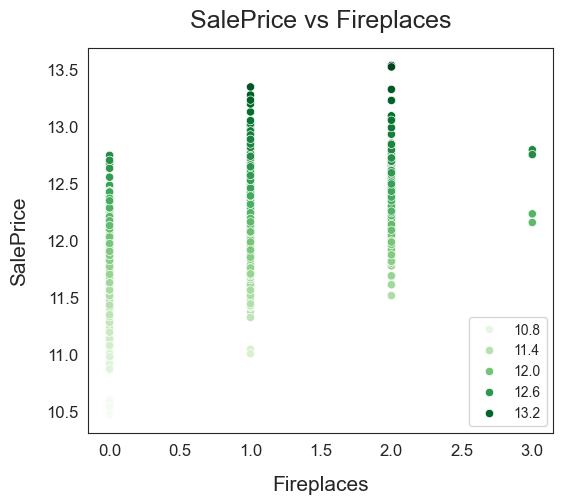

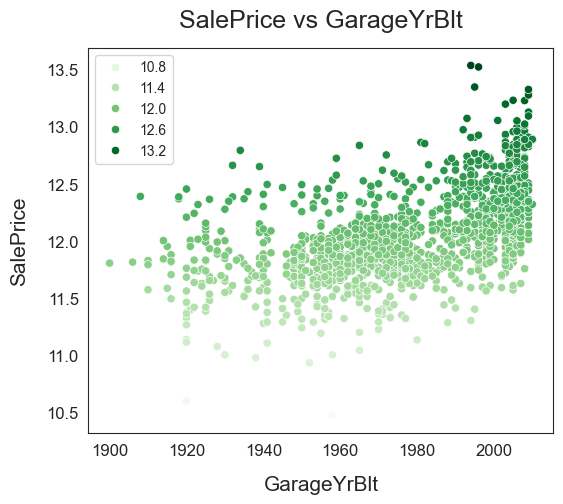

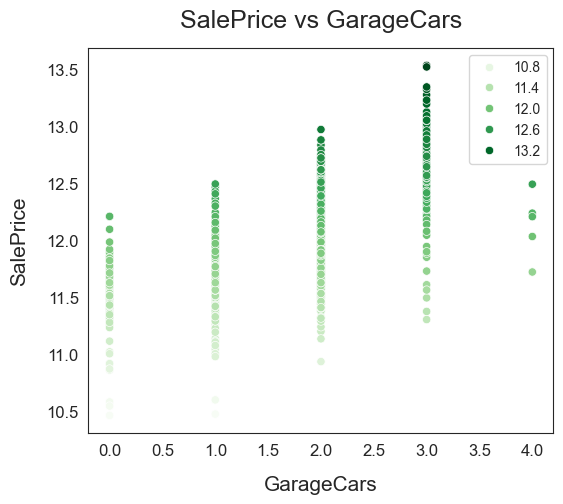

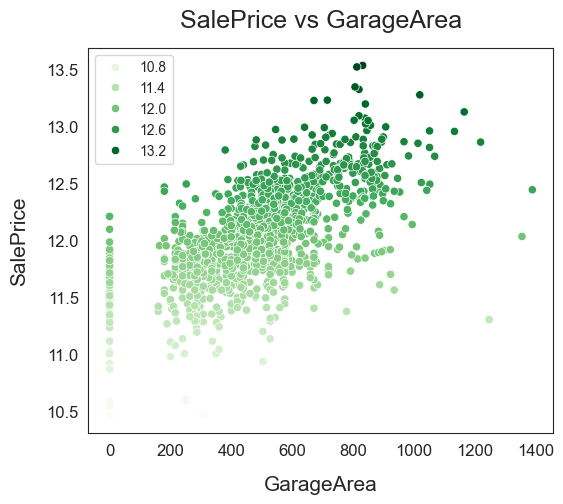

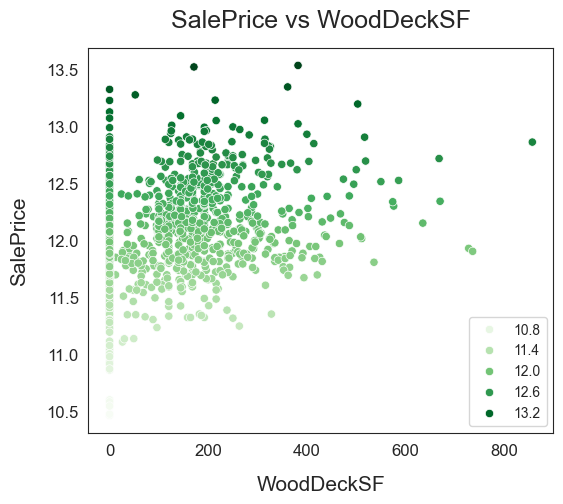

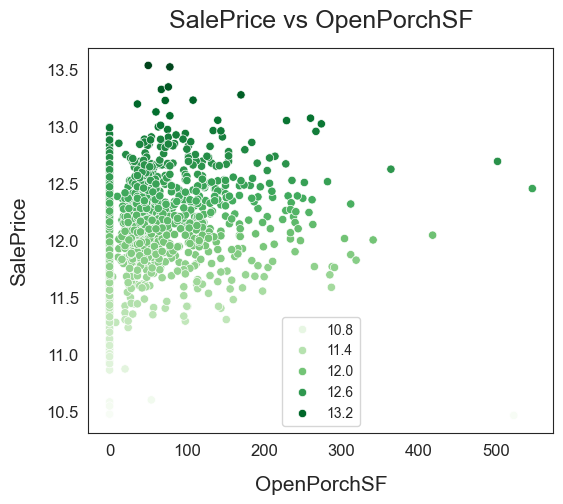

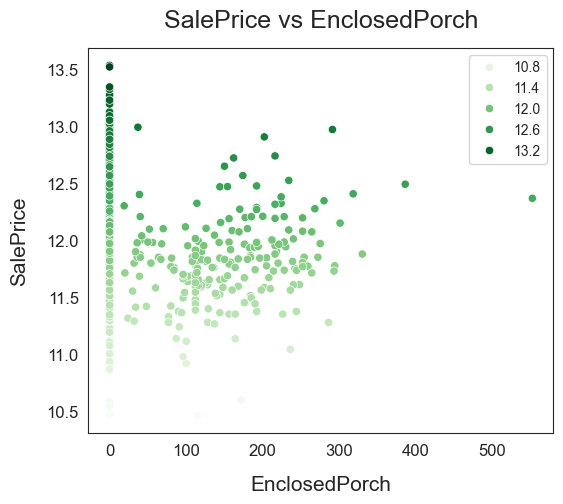

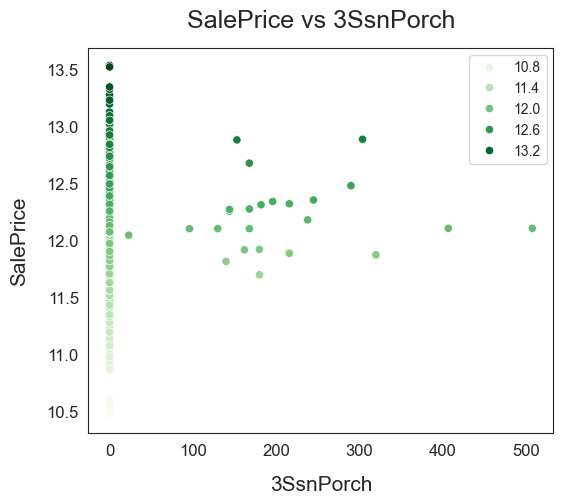

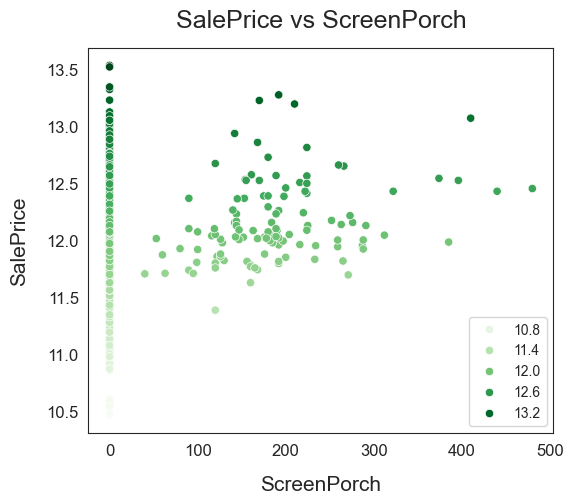

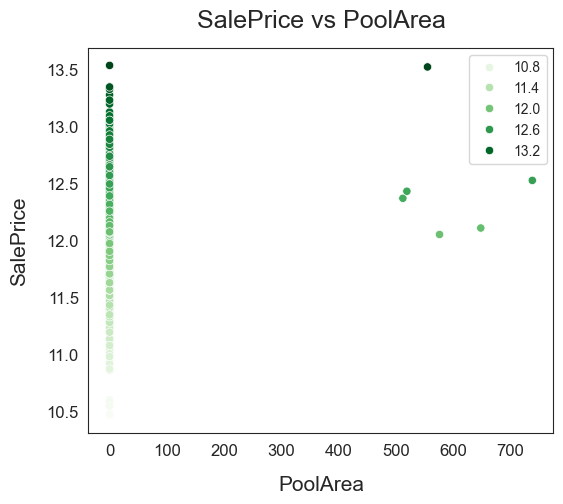

In [38]:
# Пошук числових ознак
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i not in ['TotalSF', 'Total_Bathrooms', 'Total_porch_sf', 'haspool', 'hasgarage', 'hasbsmt', 'hasfireplace']:
            numeric.append(i)

# Візуалізація викидів у значеннях даних
sns.color_palette("husl", 8)
for feature in numeric:
    if feature == 'MiscVal':
        break
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Greens', data=train)
    
    plt.xlabel(f'{feature}', size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    plt.title(f'SalePrice vs {feature}', size=18, pad=15)
    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
    
    plt.show()

# Навчання моделей

## Основні особливості процесу навчання моделей:
- **Перехресна перевірка:** Використовую 12-кратну перехресну перевірку
- **Моделі:** На кожному прогоні перехресної перевірки я підганяв 7 моделей  
(ridge, svr, градієнтний бустінг, випадковий ліс, xgboost, lightgbm регресори)
- **Стекінг:** Крім того, я навчив мета-стекінг CVRegressor, оптимізований за допомогою xgboost
- **Змішування:** Всі навчені моделі в тій чи іншій мірі підганяють навчальні дані під себе.  
Тому, щоб зробити остаточні прогнози, я об'єднав їхні прогнози разом, щоб отримати більш надійні прогнози.

## Налаштування перехресної перевірки та визначення метрик помилок

In [39]:
# Налаштування перехресної перевірки згинів
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [40]:
# Визначте метрики помилок
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

## Setup models

In [41]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                            num_leaves=6,
                            learning_rate=0.01, 
                            n_estimators=7000,
                            max_bin=200, 
                            bagging_fraction=0.8,
                            bagging_freq=4, 
                            bagging_seed=8,
                            feature_fraction=0.2,
                            feature_fraction_seed=8,
                            min_sum_hessian_in_leaf = 11,
                            verbose=-1,
                            random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Навчання моделі
### Отримайте результати перехресної перевірки для кожної моделі

In [42]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.3f} ({:.3f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(xgboost)
print("xgboost: {:.3f} ({:.3f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.14 (0.02)


In [ ]:
score = cv_rmse(svr)
print("SVR: {:.3f} ({:.3f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.111 (0.019)


In [ ]:
score = cv_rmse(ridge)
print("ridge: {:.3f} ({:.3f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.111 (0.016)


In [ ]:
score = cv_rmse(rf)
print("rf: {:.3f} ({:.3f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.137 (0.019)


In [ ]:
score = cv_rmse(gbr)
print("gbr: {:.3f} ({:.3f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.113 (0.016)


### Fit the models

In [ ]:
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

In [ ]:
lgb_model_full_data = lightgbm.fit(X, train_labels)

In [ ]:
xgb_model_full_data = xgboost.fit(X, train_labels)

In [ ]:
svr_model_full_data = svr.fit(X, train_labels)

In [ ]:
ridge_model_full_data = ridge.fit(X, train_labels)

In [ ]:
rf_model_full_data = rf.fit(X, train_labels)

In [ ]:
gbr_model_full_data = gbr.fit(X, train_labels)

## Змішуємо моделі та отримуємо прогнози

In [ ]:
# Об'єднайте моделі, щоб зробити остаточні прогнози більш стійкими до перенастроювання
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [ ]:
# Отримати остаточні уточнення зі змішаної моделі
blended_score = rmsle(train_labels, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07684201723991756


## Визначаємо найефективнішу модель

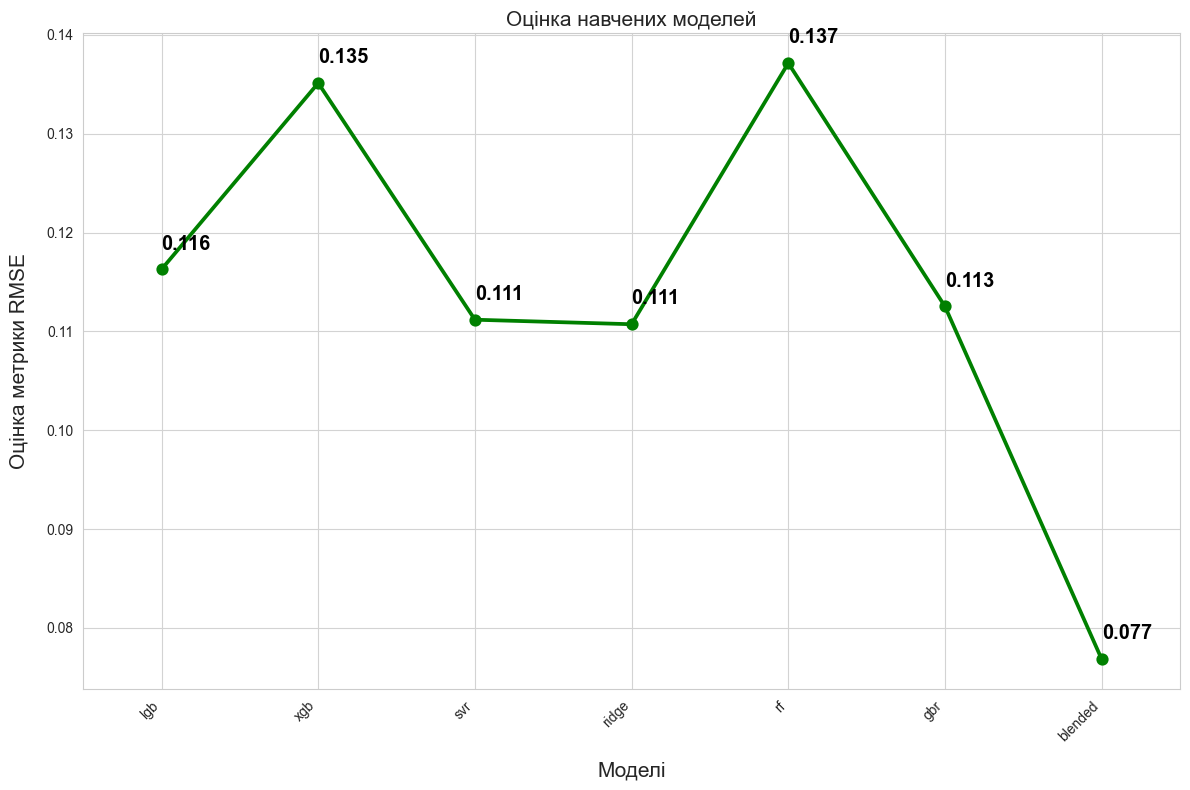

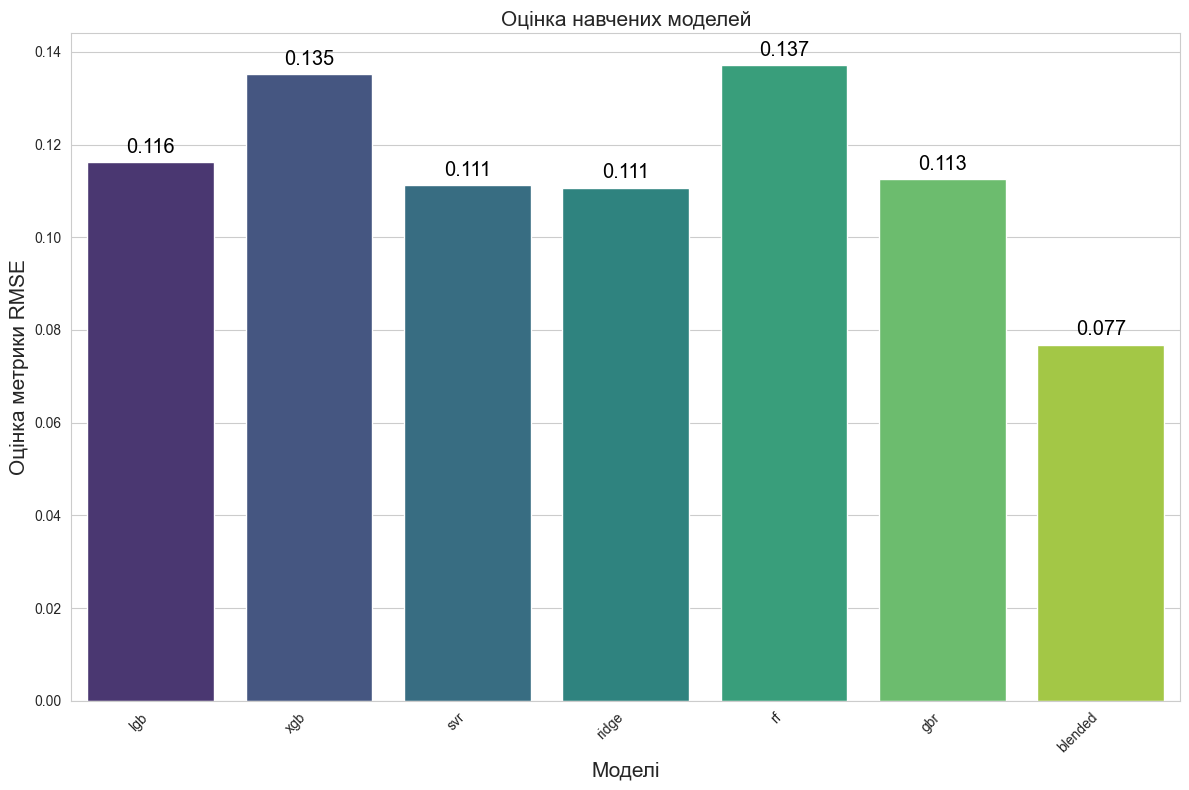

In [ ]:
# Створення DataFrame з scores
df = pd.DataFrame({'Model': list(scores.keys()), 'Score (RMSE)': [score[0] for score in scores.values()]})

# Перший графік - лінійний графік
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Лінійний графік
ax1 = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers='o', linestyles='-', color='green')
for i, score in enumerate(scores.values()):
    ax1.text(i, score[0] + 0.002, '{:.3f}'.format(score[0]), horizontalalignment='left', size='x-large', color='black', weight='semibold')

plt.ylabel('Оцінка метрики RMSE', size=15, labelpad=12.5)
plt.xlabel('Моделі', size=15, labelpad=12.5)
plt.xticks(rotation=45, ha='right')
plt.title('Оцінка навчених моделей', size=15)
plt.grid(color='lightgray')

plt.tight_layout()
plt.show()

# Другий графік - стовпчастий графік
plt.figure(figsize=(12, 8))

# Стовпчастий графік
sns.barplot(x='Model', y='Score (RMSE)', data=df, palette='viridis')

# Додавання підписів до точок
for index, row in df.iterrows():
    plt.text(index, row['Score (RMSE)'] + 0.002, f'{row["Score (RMSE)"]:.3f}', color='black', ha="center", size='x-large')

plt.title('Оцінка навчених моделей', size=15)
plt.xlabel('Моделі', size=15)
plt.ylabel('Оцінка метрики RMSE', size=15)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

На графіку вище ми бачимо, що змішана модель значно випереджає інші моделі з середньоквадратичним відхиленням (RMSLE) 0,075.  
Саме цю модель я буду використовувати для остаточних прогнозів.

## Прогнозування

In [ ]:
# Прочитати у фреймі даних sample_submission
submission = pd.read_csv("../data/sample_submission.csv")
submission.shape

(1459, 2)

In [ ]:
# Додавання прогнозів зі змішаних моделей
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test)))

In [ ]:
# Fix outleir predictions
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("../data/Y_test_pred_1.csv", index=False)

In [ ]:
# Масштабні прогнози
submission['SalePrice'] *= 1.001619
submission.to_csv("../data/Y_test_pred_2.csv", index=False)

In [ ]:
# Збереження кожної моделі у файл
joblib.dump(ridge_model_full_data, 'ridge_model_full_data.pkl')
joblib.dump(svr_model_full_data, 'svr_model_full_data.pkl')
joblib.dump(gbr_model_full_data, 'gbr_model_full_data.pkl')
joblib.dump(xgb_model_full_data, 'xgb_model_full_data.pkl')
joblib.dump(lgb_model_full_data, 'lgb_model_full_data.pkl')
joblib.dump(rf_model_full_data, 'rf_model_full_data.pkl')
joblib.dump(stack_gen_model, 'stack_gen_model.pkl')

['stack_gen_model.pkl']

In [ ]:
pred_train = blended_predictions(X)

# Перший графік: Прогнозовані ціни
plt.figure(figsize=(10, 6))
plt.plot(train_ID, np.floor(np.expm1(pred_train)), label='Прогнозована ціна', color='black')
plt.xlabel('Порядковий номер')
plt.ylabel('Ціна продажу')
plt.title('Прогнозовані ціни продажу')
plt.legend()
plt.show()

# Другий графік: Реальні ціни
plt.figure(figsize=(10, 6))
plt.plot(train_ID, np.floor(np.expm1(train_labels)), label='Фактична ціна', color='green')
plt.xlabel('Порядковий номер')
plt.ylabel('Ціна продажу')
plt.title('Фактичні ціни продажу')
plt.legend()
plt.show()

# Третій графік: Порівняння прогнозованих та реальних цін
plt.figure(figsize=(10, 6))
plt.plot(train_ID, np.floor(np.expm1(train_labels)), label='Фактична ціна', color='green', linestyle='--')
plt.plot(train_ID, np.floor(np.expm1(pred_train)), label='Прогнозована ціна', color='black')
plt.xlabel('Порядковий номер')
plt.ylabel('Ціна продажу')
plt.title('Порівняння прогнозованих та фактичних цін продажу')
plt.legend()
plt.show()
